# 0. Импортирование библиотек и Загрузка данных

**ВАЖНО!**

Рекомендуется пропустить запуск кода от EDA до очистки текста включительно (занимает ~1.5 часа) и выполнить код, начиная с главы 2.3.1.. Помимо сэкономленного времени, такой подход позволит затратить меньше памяти ОЗУ.

In [ ]:
# Загрузка датасета

# !gdown --quiet something url

In [ ]:
# Загрузка библиотеки Navec и предобученного GloVe

!pip --quiet install navec
!wget --quiet https://storage.yandexcloud.net/natasha-navec/packs/navec_hudlit_v1_12B_500K_300d_100q.tar

In [ ]:
# Загрузка библиотеки FastText

!pip --quiet install fasttext

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
# Загрузка библиотеки pymorphy2 для лемматизации

!pip --quiet install pymorphy2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 60.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
# Загрузка библиотеки Transformers

!pip --quiet install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 51.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 24.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 122.5 MB/s eta 0:00:00


In [ ]:
import re
import gc
import string
import operator
from math import ceil
from collections import defaultdict

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = stopwords.words("russian")
import pymorphy2

from navec import Navec
import fasttext
import fasttext.util

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import StratifiedKFold

from transformers import AutoTokenizer
from transformers import TFBertForSequenceClassification

import tensorflow as tf
from tensorflow import keras
from keras.optimizers import SGD, Adam
from keras.layers import Dense, Input
from keras.models import Model
from keras.callbacks import Callback

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# 1. Разведочный Анализ Данных (EDA)

## 1.1. Первичный осмотр датасета

In [ ]:
df = pd.read_excel('/content/Data_scientist_NLP_данные.xlsx')
df

Дата Категория                              Тема  \
0     2022-04-02 15:43:24.726    Вопрос                   Благоустройство   
1     2022-05-06 14:46:31.109    Вопрос  Социальное обслуживание и защита   
2     2022-01-14 07:20:51.308    Вопрос  Социальное обслуживание и защита   
3     2022-05-18 03:54:37.952    Вопрос  Социальное обслуживание и защита   
4     2022-05-20 07:33:30.558    Вопрос  Социальное обслуживание и защита   
...                       ...       ...                               ...   
29544 2022-04-11 08:42:35.514    Вопрос            Общественный транспорт   
29545 2022-05-04 07:38:28.007    Вопрос               МФЦ "Мои документы"   
29546 2022-04-15 19:15:52.086    Вопрос  Социальное обслуживание и защита   
29547 2022-07-11 07:51:28.096    Вопрос            Общественный транспорт   
29548 2022-01-12 18:48:37.840    Жалоба                            Дороги   

           Муниципалитет                                              Текст  
0      Хайбуллинский р-н  'Вид из окна потрясающий (пр. С. Юлаева напрот...  
1               Брянск г  '[id294938415:bp-88767010_4|Αнастасия], Здравс...  
2             Улан-Удэ г  '[club53367440:bp-53367440_121743|Министерство...  
3             Улан-Удэ г              'Здравствуйте когда будет выплата ДВ?  
4            Челябинск г  'Девочки всем привет,у меня такой вопрос получ...  
...                  ...                                                ...  
29544      Октябрьский г  'Добрый день.Почему подорожала плата за проезд...  
29545            Миасс г  'Миасс. Девочки подскажите номер телефона пф о...  
29546              Уфа г  'Здравствуйте почему пришел отказ?<br>db7ced5b...  
29547         Белгород г  'А НАЗАД С КАКИМ ИНТЕРВОЛОМ БУДУТ ЕЗДИТЬ АВТОБ...  
29548    Ахтубинский р-н  'Мы ходим в этот сад,я когда это увидела подум...  

[29549 rows x 5 columns]

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29549 entries, 0 to 29548
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Дата           29549 non-null  datetime64[ns]
 1   Категория      29549 non-null  object        
 2   Тема           29538 non-null  object        
 3   Муниципалитет  29549 non-null  object        
 4   Текст          29549 non-null  object        
dtypes: datetime64[ns](1), object(4)
memory usage: 1.1+ MB


In [ ]:
df.drop(columns='Дата').describe()

Категория                              Тема Муниципалитет  Текст
count      29549                             29538         29549  29549
unique         2                                31           270  29359
top       Вопрос  Социальное обслуживание и защита   Челябинск г      '
freq       24549                             10143          5325     41

Первые проблемы датасета:
1. В признаке "Тема" есть небольшое кол-во пропусков (11шт).
2. Кол-во уникальных текстов на 190 меньше от общего количества - есть дубликаты.
3. Часто встречаемым текстом является апостроф ( ' ). Встречается 41 раз. Такой текст не является информативным. Также возможно наличие в датасете подобных текстов с другими знаками препинания.

Также видим, что в признаках "Тема" и "Муниципалитет" часто встречается "Социальное обслуживание и защита" и "Челябинск г" соответственно. Возможно, это будет полезно :)

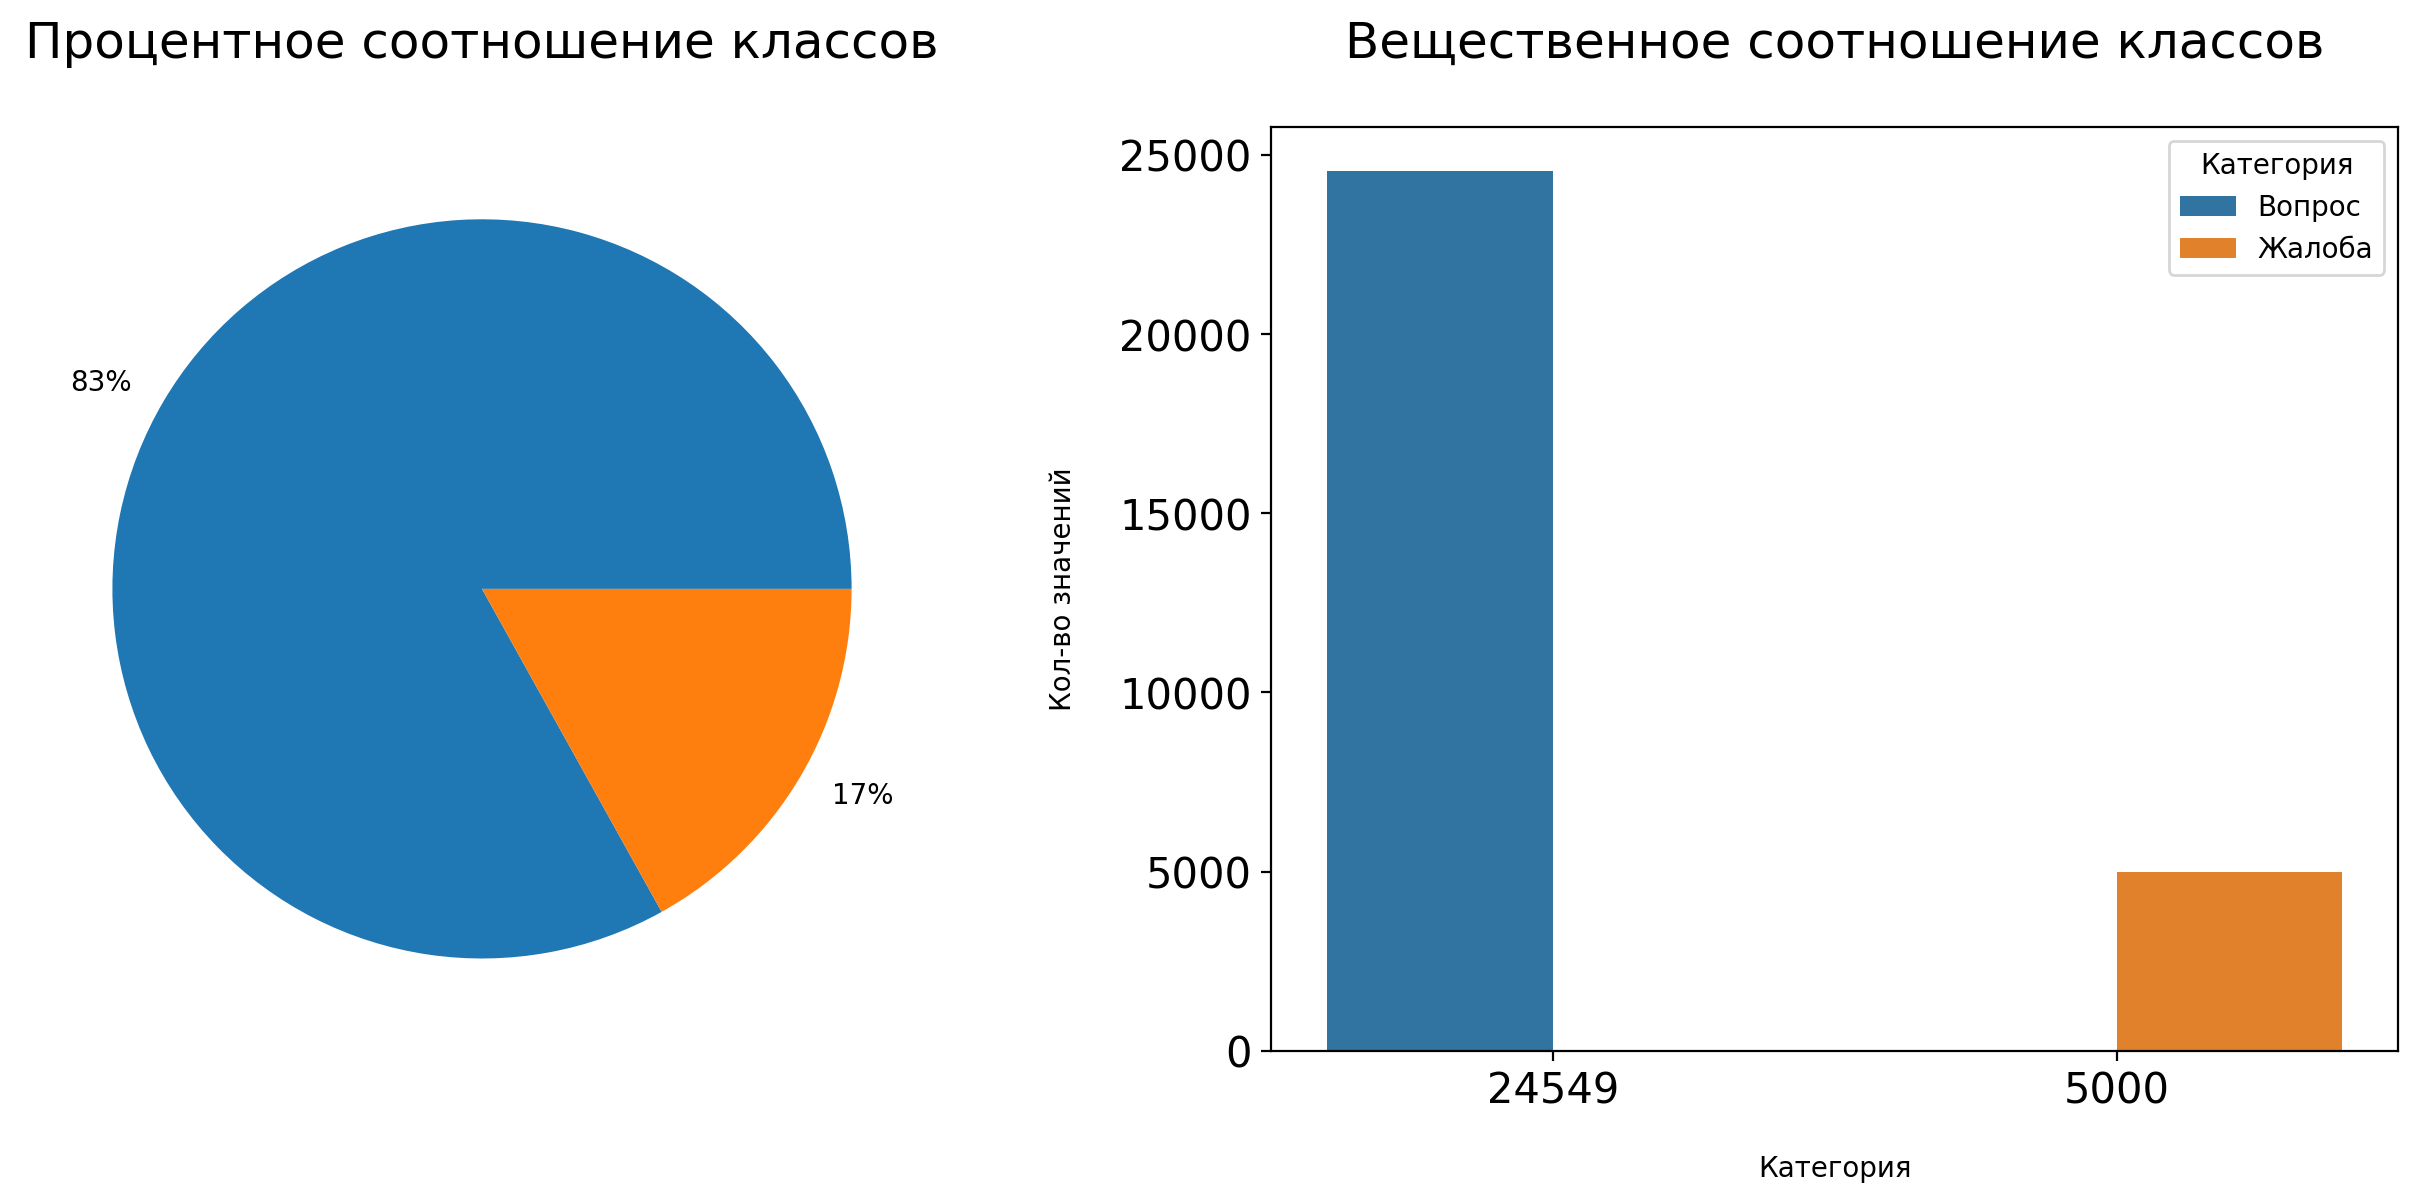

In [ ]:
# Посмотрим на соотношение классов

fig, axes = plt.subplots(ncols=2, figsize=(16, 6), dpi=200)

df.groupby('Категория')['Категория'].count().plot(kind='pie', ax=axes[0],
                                                  labels=(df['Категория']
                                                  .value_counts(normalize=True)
                                                  .round(2) * 100).astype(int)
                                                  .astype(str) + '%')
sns.countplot(x=df['Категория'], hue=df['Категория'], ax=axes[1])

axes[0].set_ylabel('')
axes[1].set_xlabel('Категория', labelpad=15)
axes[1].set_ylabel('Кол-во значений', labelpad=15)
axes[1].set_xticklabels(df['Категория'].value_counts())
axes[0].tick_params(axis='x', labelsize=15)
axes[0].tick_params(axis='y', labelsize=15)
axes[1].tick_params(axis='x', labelsize=15)
axes[1].tick_params(axis='y', labelsize=15)

axes[0].set_title('Процентное соотношение классов', fontsize=18, pad=25)
axes[1].set_title('Вещественное соотношение классов', fontsize=18, pad=25)

plt.show()

Есть дисбаланс классов

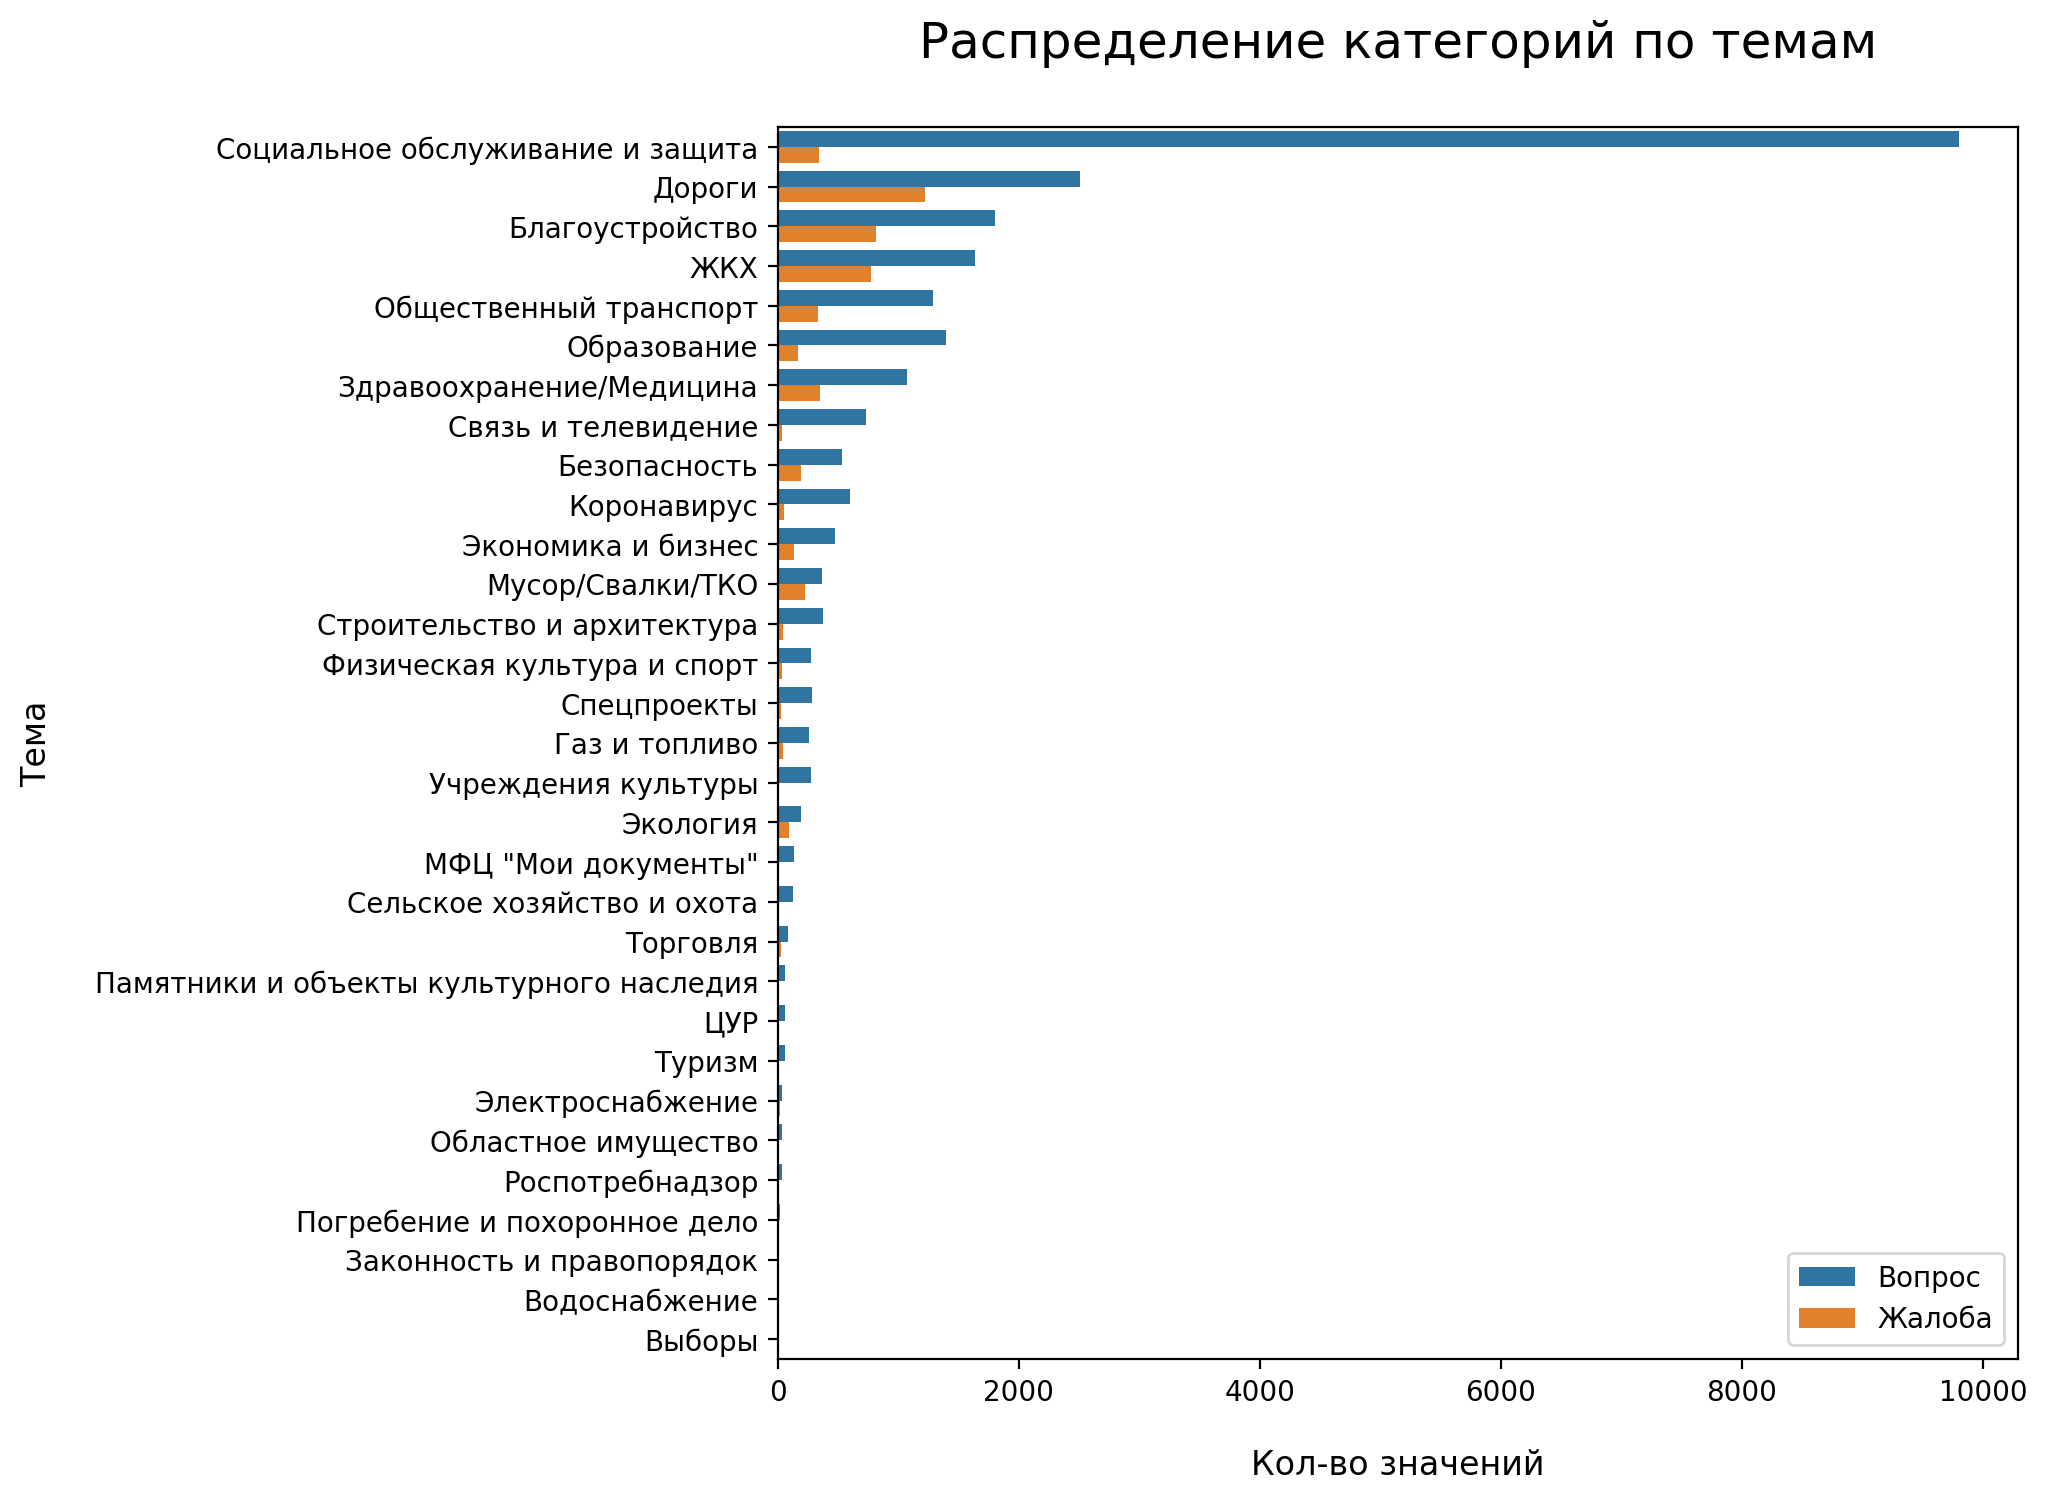

In [ ]:
df['target_count'] = df.groupby('Тема')['Категория'].transform('count')

plt.figure(figsize=(8, 8), dpi=200)

sns.countplot(y=df.sort_values(by='target_count', ascending=False)['Тема'],
              hue=df.sort_values(by='target_count', ascending=False)['Категория'])


plt.title('Распределение категорий по темам', pad=25, fontdict={'fontsize': 18})
plt.xlabel('Кол-во значений',labelpad=15, fontdict={'fontsize': 12})
plt.ylabel('Тема',labelpad=15, fontdict={'fontsize': 12})
plt.legend(loc=4)

plt.show()

df.drop(columns=['target_count'], inplace=True)

По графику распределений категорий по темам мы можем наблюдать, что в основном жалобы поступают на тему дорог (неудивительно), благоустройства и ЖКХ. Большую часть вопросов датасета занимает тема "Социальное обслуживание и защита" и те же дороги, благоустройство и ЖКХ.

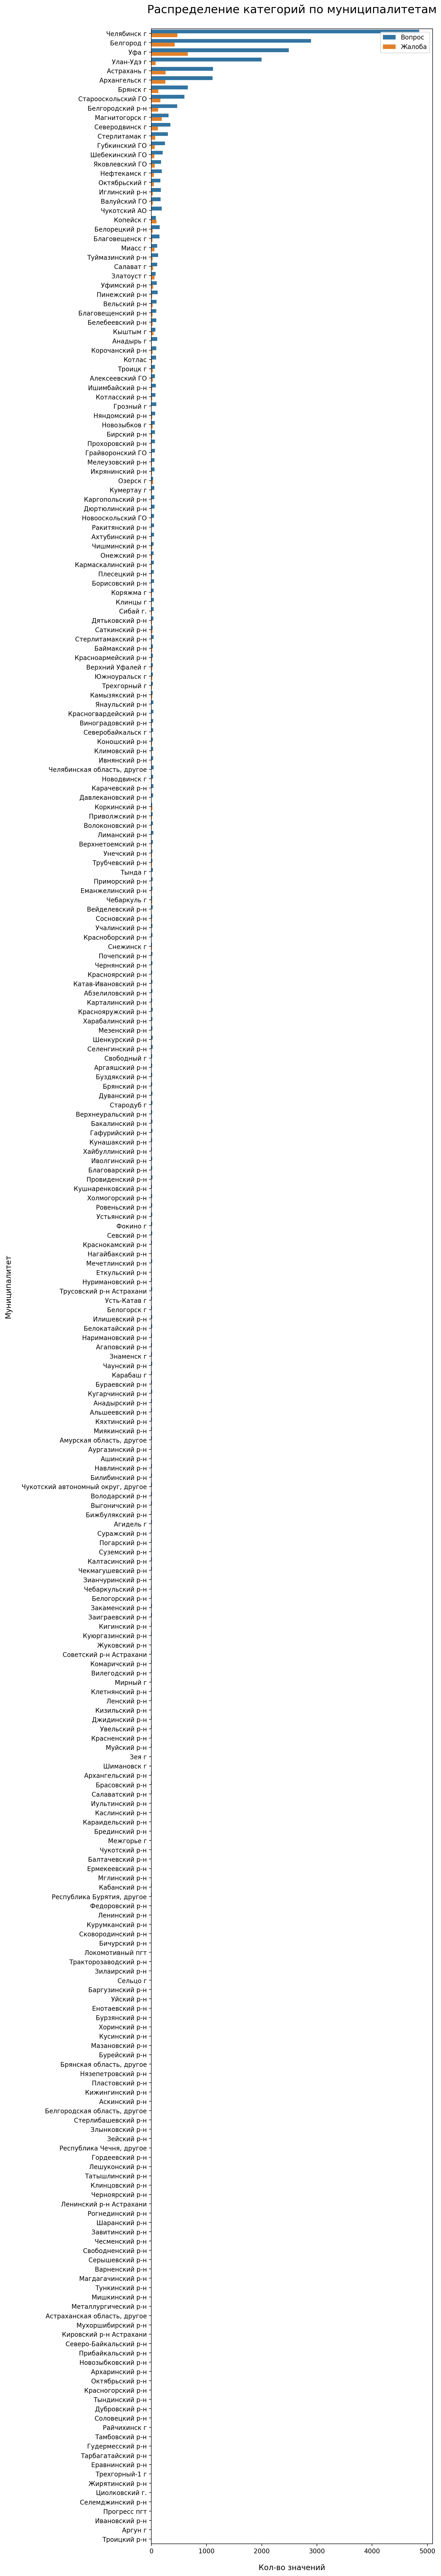

In [ ]:
df['target_count'] = df.groupby('Муниципалитет')['Категория'].transform('count')

plt.figure(figsize=(8, 72), dpi=200)

sns.countplot(y=df.sort_values(by='target_count', ascending=False)['Муниципалитет'],
              hue=df.sort_values(by='target_count', ascending=False)['Категория'])


plt.title('Распределение категорий по муниципалитетам', pad=25, fontdict={'fontsize': 18})
plt.xlabel('Кол-во значений',labelpad=15, fontdict={'fontsize': 12})
plt.ylabel('Муниципалитет',labelpad=15, fontdict={'fontsize': 12})
plt.legend(loc=1)

plt.show()

df.drop(columns=['target_count'], inplace=True)

По графику распределений категорий по муниципалитетам мы можем наблюдать, что в основном жалобы поступают в Уфе, Челябинске, Белгороде. большую часть вопросов датасета приходится на Челябинск, Белгород, Уфу, Улан-Удэ и Астрахань с Архангельском.

Вышеизложенное говорит нам о том, что признаки 'Тема' и 'Муниципалитет' являются полезными для дальнейшей работы.

Теперь проверим на полезность признак 'Дата'. Разобьём выборку на интервалы год/месяц/день/час, посмотрим сколько уникальных значений получится и оставим тот формат, который будет содержать их приемлемое кол-во.

In [ ]:
mask = df['Дата']

print(f'Кол-во уникальных значений по годам: {len(mask.dt.year.unique())}')
print(f'Кол-во уникальных значений по месяцам: {len(mask.dt.month.unique())}')
print(f'Кол-во уникальных значений по часам: {len(mask.dt.hour.unique())}')

Кол-во уникальных значений по годам: 1
Кол-во уникальных значений по месяцам: 7
Кол-во уникальных значений по часам: 24


В данном датасете нет смысла конкатенировать год с остальными интервалами для получения нового признака, поскольку он всего один. Добавив его, мы снизим наглядность графиков :)

In [ ]:
dt = (mask.dt.month.astype(str) + '/' + mask.dt.day.astype(str)
     + '/' + mask.dt.hour.astype(str))

print(f'Кол-во уникальных значений в формате ММ/ДД/ЧЧ: {len(dt.unique())}')

Кол-во уникальных значений в формате ММ/ДД/ЧЧ: 4133


Нужно убрать дни, из-за них слишком много уникальных значений. А вообще, лучше создать отдельные признаки по месяцам и по часам, так будет информативней.

In [ ]:
# Удалим ненужную переменную и очистим мусор в памяти

del dt
gc.collect()

71278

In [ ]:
# Создаём признаки по месяцам и часам. Называем также на русском, 
# не будем выбиваться из стилистики :)

df['Месяц'] = mask.dt.month
df['Час'] = mask.dt.hour

Теперь посмотрим распределение категорий во времени.

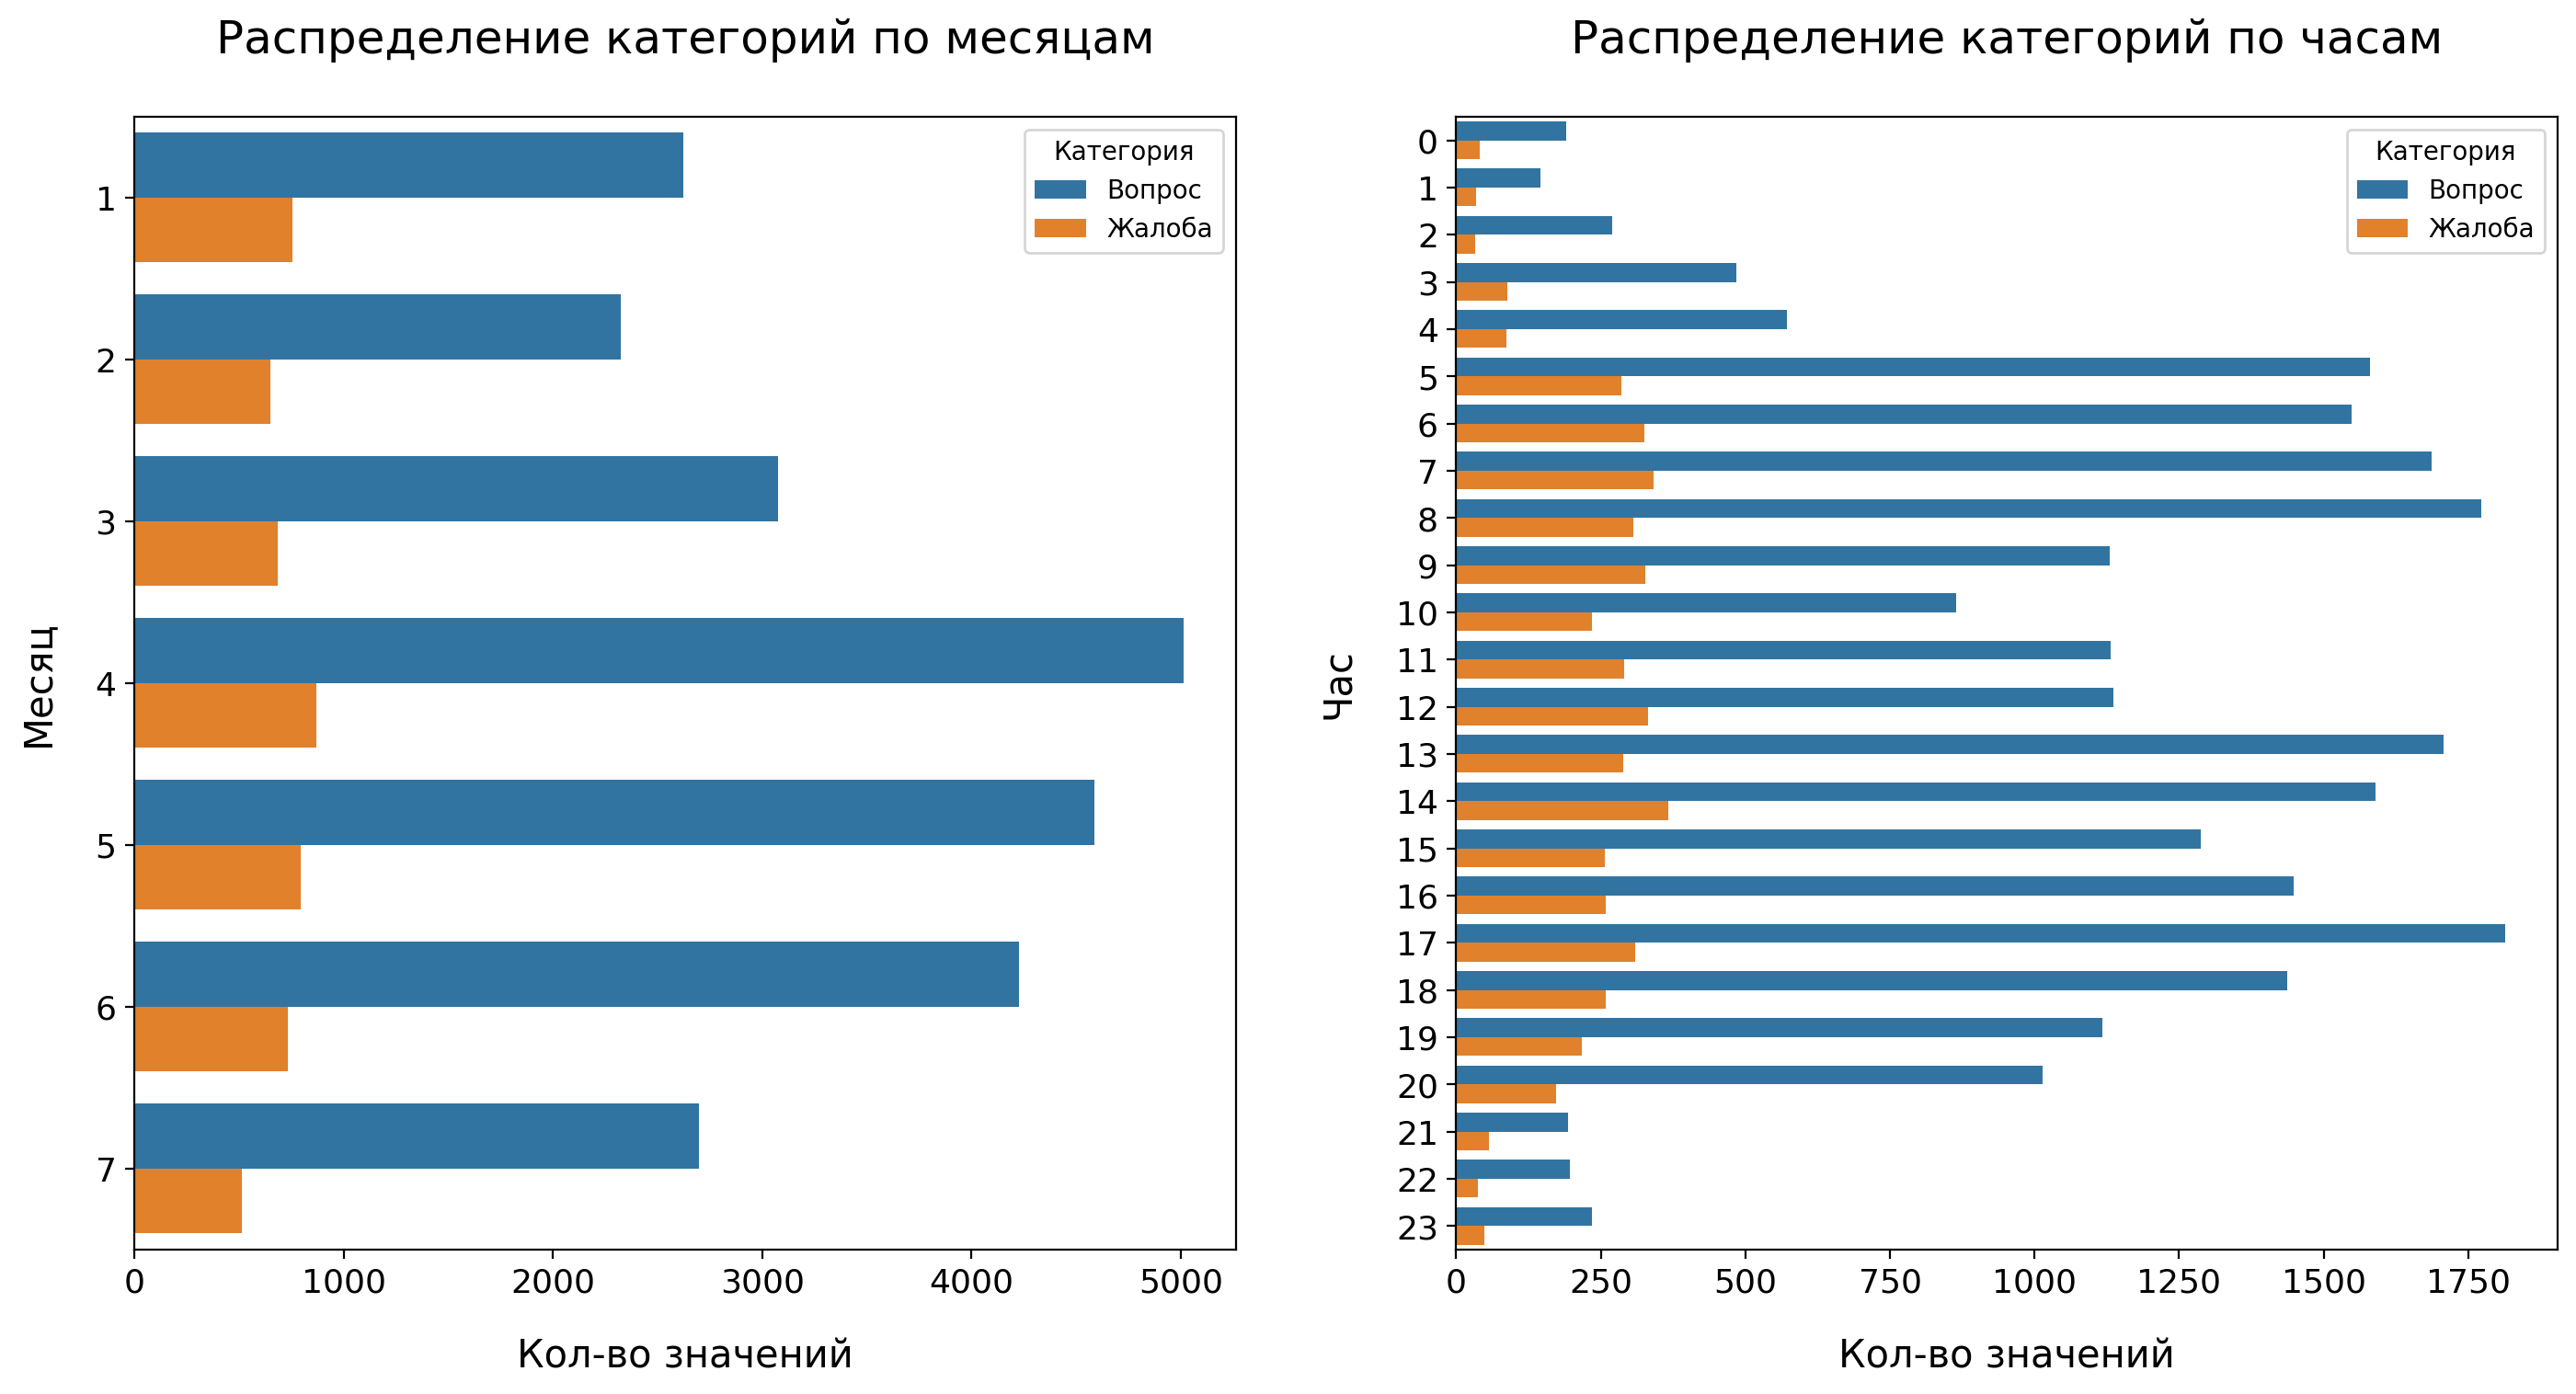

In [ ]:
df['target_months_mean'] = df.groupby('Категория')['Месяц'].transform('mean')
df['target_hours_mean'] = df.groupby('Категория')['Час'].transform('mean')

fig, axes = plt.subplots(ncols=2, figsize=(17, 8), dpi=200)

sns.countplot(y=df.sort_values(by='target_months_mean', ascending=False)['Месяц'],
              hue=df.sort_values(by='target_months_mean', ascending=False)['Категория'],
              ax=axes[0])
sns.countplot(y=df.sort_values(by='target_hours_mean', ascending=False)['Час'],
              hue=df.sort_values(by='target_hours_mean', ascending=False)['Категория'],
              ax=axes[1])

axes[0].set_xlabel('Кол-во значений', size=15, labelpad=15)
axes[0].set_ylabel('Месяц', size=15, labelpad=15)
axes[1].set_xlabel('Кол-во значений', size=15, labelpad=15)
axes[1].set_ylabel('Час', size=15, labelpad=15)

axes[0].tick_params(axis='x', labelsize=13)
axes[0].tick_params(axis='y', labelsize=13)
axes[1].tick_params(axis='x', labelsize=13)
axes[1].tick_params(axis='y', labelsize=13)

axes[0].set_title('Распределение категорий по месяцам', fontsize=18, pad=25)
axes[1].set_title('Распределение категорий по часам', fontsize=18, pad=25)

plt.show()

df.drop(columns=['target_months_mean', 'target_hours_mean'], inplace=True)

По месяцам критичной разницы не наблюдается, а вот по часам видно, когда приходится пик активности вопросов и жалоб. Обычно, это с 5 утра до 8 часов вечера. Такой большой диапазон можно объяснить разным часовым поясом муниципалитетов. Новые признаки дальше будут полезны.

Теперь, давайте взглянем на характер вопросов и жалоб. Напишем небольшую функцию для удобного чтения, так как в Колабе плохо реализован вывод текста, а затем прочитаем по 20 случайных текстов с вопросами и жалобами.

In [ ]:
def readable(lst: list, max_len_rows: int = 90) -> print():
  """
  Функция фиксирует размер текста при вызове функции print(),
  а также нумерует последовательность текстов.
  Аргументы: 
  lst - список текстов;
  max_len_rows - максимальная длина выводимой строки.
  Результат:
  Пронумерованный текст с фиксированной длиной строк,
  вызванный функцией print()
  """

  for n, t in enumerate(lst):
    n_prints = ceil(len(t) / max_len_rows)
    print(str(n + 1) + '.')

    for j in range(n_prints):
      print(t[j*max_len_rows:max_len_rows*(j + 1)])
    
      if (j+1) == n_prints:
        print()

In [ ]:
# Вопросы

readable(df[df['Категория'] == 'Вопрос']
         .sample(20, random_state=14)
         ['Текст'].values.tolist())

1.
'Скажите пожалуйста а беженцы с Украины могут получить по 10 тисяч или только ЛНР и ДНР

2.
'Предлагаю главе округа встретиться с населением округа, в частности поселка Затон. Думаю,
 эта встреча будет полезна и администрации и населению.<br>Имеются ли какие -либо планы на
 этот счёт?

3.
'Полная замена канализационного стояка всего подъезда это явно не статья "расходы на содер
жание". И даже не текущий ремонт... когда хомут вам поставят или дырку заварят.<br>Больше 
тянет на капитальный ремонт. А на него сами знаете, кто собирает деньги по отдельной квита
нции. Только в каком году капремонт запланирован в вашем доме, вы же в курсе? Тогда точно 
всё будет бесплатно.<br>На мой взгляд, жильцам не стоит выёживаться, а проще скинуться на 
трубу; дешевле обойдется, чем выносить горшки на улицу.

4.
'Когда путинские будут?

5.
'Когда диалог с учителями будет?

6.
'Добрый день. Подскажите, пожалуйста, какая УК должна убирать парковку от снега (напротив 
дома Магистральная 2) выделенную на 

In [ ]:
# Жалобы

readable(df[df['Категория'] == 'Жалоба']
         .sample(20, random_state=14)
         ['Текст'].values.tolist())

1.
'Подходишь мусор выбросить, так резко выпрыгивают из бака😡

2.
'Здравствуйте по ул Красная Мельница засыпали но не до конца, а именно где мост там больши
е ямы хотя бы засыпали бы.

3.
'Мой ребёнок занимается в спортивной школе, но в этом году дети вышли на склон всего пару 
раз а всё потому что комплекс закрыт из-за сноса гостиницы! Неужели нельзя вести эти работ
ы вечером, когда занятий нет ?? А по уму бы по окончанию сезона весной или летом ! Переста
ньте делать вид что ничего не знаете ! У нас пропадают тренировки, дети хотят заниматься!

4.
'Уважаемая администрация города Миасса когда будет осуществляться ремонт динамовского шосс
е в сторону Златоуста пока вы соберётесь там новая дорога вся дырявая уже стык примыкания 
асфальта рассходится, края обочины в конкретных дарах и по середине дороги тоже огромные д
ыры.

5.
'Добрый вечер, Вячеслав Владимирович! Прошу проверить работы по устройству асфальта в юго-
западном 2.1. Украли асфальта на миллионы, ширина дорог не соответвует п

Первая разница, которая отличает вопросы от жалоб - это объёмы текстов. Очевидно, что в жалобах их больше. Также в жалобах больше присутствует негативного очерка и уникальных слов. Ну, как пример, жалоба под номером 16, небольшой её отрывок: "'[id592224538|Федор], с какого хэ цены на продукты подняли?". 

Оценка характера вопросов и жалоб даёт нам понимание особенностей текстов датасета, что в свою очередь пригодится для грамотной очистки текста.

Далее следует начать с удаление дубликатов, а не с заполнения пропусков, поскольку объекты с пропущенными значениями в признаке 'Тема' могут также являтся дубликатами в признаке 'Текст'. Просто экономия времени.

## 1.2. Удаление дубликатов

In [ ]:
# Для начала взглянем на дубликаты

df[df['Текст'].duplicated()]

Дата Категория                 Тема   Муниципалитет  \
1263  2022-05-10 17:11:06.364    Вопрос               Дороги  Шебекинский ГО   
1434  2022-04-02 16:44:08.827    Жалоба             Экология     Челябинск г   
1487  2022-03-06 18:56:34.765    Вопрос                  ЖКХ     Астрахань г   
1750  2022-02-12 10:53:30.564    Жалоба               Дороги   Суземский р-н   
2141  2022-02-04 14:20:13.924    Вопрос      Благоустройство  Северодвинск г   
...                       ...       ...                  ...             ...   
29034 2022-01-25 16:55:32.955    Жалоба               Дороги  Северодвинск г   
29126 2022-05-22 15:30:01.757    Вопрос  Связь и телевидение       Коряжма г   
29276 2022-05-12 21:18:45.441    Вопрос                  ЖКХ  Северодвинск г   
29305 2022-07-10 14:45:23.583    Вопрос      Благоустройство     Астрахань г   
29400 2022-03-28 14:35:58.344    Жалоба               Дороги   Коношский р-н   

                                                   Текст  Месяц  Час  
1263                                                   '      5   17  
1434                                                   '      4   16  
1487                                                   '      3   18  
1750                                                   '      2   10  
2141                                       'Здравствуйте      2   14  
...                                                  ...    ...  ...  
29034                              'Сообщение без текста      1   16  
29126  'Здравствуйте, подскажите, как можно получить ...      5   15  
29276                         'Когда отключат отопление?      5   21  
29305  '[club70436592|Администрация Астрахани], а по ...      7   14  
29400                              'Сообщение без текста      3   14  

[190 rows x 7 columns]

Заметим, что среди дубликатов есть такие тексты как " 'Здравствуйте", " 'Сообщение без текста", которые не несут никакой смысловой нагрузки и создают шум в данных. Позже, следует попробовать очистить датасет от подобных текстов.

Также наблюдаются тексты, которые в начале содержат квадратные скобки, в которых есть некий идентификатор и название учреждения. Возможно такие тексты содержат в себе полезную информацию для классификации.

In [ ]:
# Удалим дубликаты, оставляя самое первое сообщение по дате

df = df.sort_values('Дата').drop_duplicates('Текст', keep='first')

## 1.3. Первичная оценка и частичное удаление неинформативного текста

Ранее, случайно встретив неинформативные тексты, мы можем удалить их, тем самым сделать очистку данных чуть более точнее. Также, зачастую неинформативный характер несут предложения из одного слова. Давайте взглянем на такие.

In [ ]:
df[df['Текст'].apply(lambda x: len(x.split(' '))) == 1]

Дата Категория                              Тема  \
19196 2022-01-19 14:19:19.705    Жалоба                            Дороги   
13913 2022-01-23 16:07:37.778    Жалоба                          Экология   
27299 2022-02-01 10:46:36.497    Вопрос               Связь и телевидение   
2141  2022-02-04 14:20:13.924    Вопрос                   Благоустройство   
8232  2022-02-12 20:14:32.681    Вопрос               Связь и телевидение   
25386 2022-02-20 13:18:24.433    Вопрос                       Образование   
2675  2022-03-01 19:03:08.480    Жалоба                   Благоустройство   
24842 2022-03-02 13:27:03.206    Жалоба                               ЖКХ   
5116  2022-03-15 17:02:27.290    Вопрос               Областное имущество   
4249  2022-04-05 18:08:34.571    Вопрос               Связь и телевидение   
15759 2022-04-05 20:41:32.412    Жалоба                Экономика и бизнес   
7010  2022-04-11 20:28:29.475    Жалоба                            Дороги   
18801 2022-04-16 21:53:03.620    Вопрос            Общественный транспорт   
2811  2022-04-20 18:35:42.256    Вопрос                            Дороги   
14765 2022-04-20 18:36:17.765    Вопрос                            Дороги   
5002  2022-05-03 18:50:53.743    Вопрос               Связь и телевидение   
3429  2022-05-15 14:21:37.226    Вопрос               Связь и телевидение   
5774  2022-05-25 20:41:18.649    Вопрос                            Дороги   
9780  2022-05-27 05:04:29.493    Вопрос            Общественный транспорт   
13308 2022-06-01 06:41:57.940    Вопрос            Общественный транспорт   
22448 2022-06-20 12:02:45.174    Вопрос  Социальное обслуживание и защита   
27719 2022-06-22 03:42:33.226    Вопрос        Сельское хозяйство и охота   
10238 2022-06-23 08:12:48.177    Вопрос  Социальное обслуживание и защита   
26448 2022-07-03 08:30:39.362    Вопрос               Связь и телевидение   
21617 2022-07-06 16:00:51.380    Жалоба                   Благоустройство   
2995  2022-07-08 18:54:51.625    Вопрос                   Благоустройство   

          Муниципалитет                                              Текст  \
19196       Астрахань г                                                  '   
13913       Челябинск г                                       '23.01.2022.   
27299     Архангельск г                                          'спасибо)   
2141     Северодвинск г                                      'Здравствуйте   
8232     Котласский р-н                                            'Начать   
25386    Приморский р-н                                               '483   
2675           Озерск г                                         'Любуйтесь   
24842         Копейск г                           'VID_20220302_143711.mp4   
5116    Кунашакский р-н                                     'Здравствуйте!   
4249     Котласский р-н  'https://genuineneutral.top/GZSbJWqA/lukoil/?_...   
15759        Белгород г                               '[id621511727|Анна],   
7010        Челябинск г                                            'Дворы!   
18801    Шенкурский р-н                                        'Ежедневно?   
2811        Челябинск г                                        'Мастеровая   
14765       Челябинск г                                          'Линейная   
5002     Северодвинск г                                     'Здравствуйте.   
3429     Няндомский р-н                                       'Здраствуйте   
5774        Астрахань г                                     'Администрация   
9780         Улан-Удэ г                                               '19?   
13308    Шенкурский р-н  'И.мне.бы.хотелось.знать.как.ездит.автобус.на....   
22448          Брянск г                                           'Спасибо   
27719  Туймазинский р-н                                             'Цена?   
10238          Брянск г                             '042-22-001-6830-7241)   
26448     Кигинский р-н                                          'Сегодня

Как мы можем наблюдать, есть ещё неинформативные тексты такие, как даты, идентификаторы, ссылки и названия видео. Последние два, возможно что-то показывают, например в видео могли задать какой-то вопрос или изъявить недовольство. Но поскольку у нас только название таких видео или ссылок, то для нас они не являются информативными.

Тонкая грань в определении того, когда текст является информативным, а когда нет. Например объект под индексом 25386 содержит в себе текст "'483" и отмечен как "Вопрос". На первый взгляд это не кажется вопросом, но вполне может им быть. Возможно шли какие-то обсуждения по улучшению условий, например, какой-то школы. А затем, таким кратким образом, некий пользователь решил спросить про другую школу, под номером 483, коснутся ли её такие же улучшения.

Что в таких ситуациях считать информативным, конено же, предмет дискуссий. 

Выявление того, какого типа бывают шумы в датасете, в дальнейшем нам поможет.

Облегчим задачу перед основной очисткой, удалив попавшиеся нам неинформативные тексты вручную.

In [ ]:
UNINFORMATIVE_TEXT = ["'Сообщение без текста", 
                      "'Здравствуйте", 
                      "'Здравствуйте.",
                      "'Здравствуйте!",
                      "'спасибо)",
                      "'23.01.2022.",
                      "'Спасибо",
                      "'VID_20220302_143711.mp4",
                      "'https://genuineneutral.top/GZSbJWqA/lukoil/?_t=1649176929564#1649177537742",
                      "'[id621511727|Анна],",
                      "'042-22-001-6830-7241)",
                      "'[id11845546|Регина],",
                      "'VID_20220708_213836.mp4",
                      "'",
                      '']

df.drop(df[df['Текст'].isin(UNINFORMATIVE_TEXT)].index, inplace=True)

In [ ]:
# Очищаем

del UNINFORMATIVE_TEXT
gc.collect()

5201

Также удалим ненужный апостроф в начале текстов

In [ ]:
# Проверим, все-ли объекты в датасете начинаются с '

mask = df[df['Текст'].apply(lambda x: x[0] == "'")]

print(f'Общее кол-во объектов в датасете: {len(df)}')
print(f'Кол-во объектов в датасете начинающихся с \': {len(mask)}')

Общее кол-во объектов в датасете: 29345
Кол-во объектов в датасете начинающихся с ': 29345


In [ ]:
# Ок, чистим

del mask
gc.collect

<function gc.collect(generation=2)>

In [ ]:
# Удаляем '

df['Текст'] = df['Текст'].apply(lambda x: x[1:])

Далее заполним пропуски.

## 1.4. Заполнение пропусков

In [ ]:
print('Кол-во пропусков: {}'.format(len(df[df['Тема'].isna()])))

Кол-во пропусков: 10


Пропусков немного, было 11, стало 10, (* проверил, при удалении дубликатов пропал дубликат с пропуском) поэтому попробуем заполнить вручную, чтобы не создавать новое уникальное значение.

Вопрос к авторам: Это такая проверка на знание придметной области (политика, социалка)? Если да, то прикольно придумали. Заставляет разобраться и вникнуть :)

In [ ]:
# Данная ячейка кода нужна для сверки конкретной темы с текстом, чтобы более
# точно определить пропущенные значения

(df[df['Тема'] == 'ЦУР'].sample(n=10, random_state=14)
[['Муниципалитет', 'Текст']])

Муниципалитет                                              Текст
9673                Уфа г  Здравствуй те, могу я написать вопрос в личные...
6539             Брянск г                    Нууу... и где видео с ответами?
4367                Уфа г       куда обращаться ..можем взять семью к себе .
10877               Уфа г  Хочу обратить ваше внимание на реализацию в го...
14289           Грозный г  Скажите как можно увидится с Рамзаном Ахматови...
16528        Уфимский р-н  Скажите пожалуйста, график разъездного приема ...
18864               Уфа г  А кто будет проверять собак привитый они или н...
27015         Челябинск г  Не совсем понятно: нельзя выгуливать собак око...
10840               Уфа г  Здравствуйте! Где можно посмотреть ваши доклад...
6946   Благовещенский р-н                                   Салют где будет?

Стоит отметить, когда в предыдущей ячейке проводилось сравнение пропущенных тем с размеченными темами, было обнаружено много несоответствий текстов с темами. Поэтому, очень сложно будет присваивать темы, ориентируясь на датасет с такими несоответствиями.

In [ ]:
# Уникальные значения по 'Тема'

df['Тема'].unique()

array(['Здравоохранение/Медицина', 'Общественный транспорт',
       'Связь и телевидение', 'Газ и топливо', 'Образование',
       'Благоустройство', 'Социальное обслуживание и защита', 'ЦУР',
       'Физическая культура и спорт', 'Мусор/Свалки/ТКО',
       'Законность и правопорядок', 'Экономика и бизнес', 'Дороги', 'ЖКХ',
       'Строительство и архитектура', 'Торговля', 'Учреждения культуры',
       'Электроснабжение', 'Коронавирус', 'Безопасность', 'Экология',
       'Сельское хозяйство и охота', 'МФЦ "Мои документы"',
       'Памятники и объекты культурного наследия', 'Спецпроекты',
       'Областное имущество', 'Роспотребнадзор',
       'Погребение и похоронное дело', 'Туризм', nan, 'Водоснабжение',
       'Выборы'], dtype=object)

In [ ]:
# Выведем на дисплей объекты с пропусками

df[df['Тема'].isna()][['Муниципалитет', 'Текст']]

Муниципалитет  \
15157                      Белорецкий р-н   
17988                    Мелеузовский р-н   
11866                               Уфа г   
26499                      Белорецкий р-н   
28458  Чукотский автономный округ, другое   
21314                          Белгород г   
8919                       Илишевский р-н   
13476                               Уфа г   
5989                                Уфа г   
1551                        Октябрьский г   

                                                   Текст  
15157  [club172754458|Администрация Белорецкого район...  
17988                       В Мелеузе к кому обращаться?  
11866  Добрый день.Говорят, в Конгресс холле сегодня ...  
26499                Где можно фото для шествия зделать?  
28458  Да, поясните, пожалуйста, что делать с субсиди...  
21314  здраствуйте, хотелось бы узнать по поводу прод...  
8919   Кого на районный сабантуй будете приглашать из...  
13476  Здравствуйте уважаемый...как дозвониться до су...  
5989   Здравствуйте можно записатся на прием к Радий ...  
1551   Почему глава Республики добавляет граждан в чë...

In [ ]:
# Заполняем

# Темы присвоены в соответствующем порядке предыдущей ячейки.
# Данный выбор несёт субъективный характер.
themes_for_nan = [
    'Социальное обслуживание и защита',
    'Социальное обслуживание и защита',
    'Связь и телевидение',
    'ЦУР',
    'Социальное обслуживание и защита',
    'Социальное обслуживание и защита',
    'ЦУР',
    'Социальное обслуживание и защита',
    'Спецпроекты',
    'ЦУР'
]

nan_idx = df[df['Тема'].isna()][['Муниципалитет', 'Текст']].index

for i in range(len(nan_idx)):
  df.loc[nan_idx[i], 'Тема'] = themes_for_nan[i]

print(f'Осталось пропусков: {df.isna().sum().sum()}')

Осталось пропусков: 0


In [ ]:
# Чистим

del themes_for_nan, nan_idx
gc.collect()

20

## 1.5. Распределение метапризнаков

Распределение метапризнаков в наборе данных может быть полезно для выявлений жалоб. Как было ранее установлено, жалобы обычно больше текстом и чаще имеют негативный окрас. 

Необходимо создать метапризнаки:
 * Кол-во слов
 * Кол-во уникальных слов
 * Средняя длина слов
 * Кол-во символов
 * Кол-во стоп-слов
 * Кол-во символов пунктуации
 * Кол-во HTML-разметки (часто замечался \<br> и \</br>), 
 * Кол-во ссылок
 * Кол-во идентификаторов (пример: [club70436592|Администрация Астрахани])



In [ ]:
# Названия столбцов пишем на русском не только из-за сохранения стилистики
# (на английском писать, конечно, проще), но и для дальнейшего 
# автоматизированного наименования графиков

df['Кол-во слов'] = df['Текст'].apply(lambda x: len(x.split()))
df['Кол-во уникальных слов'] = df['Текст'].apply(lambda x: len(set(x.split())))
df['Средняя длина слов'] = (
    df['Текст'].apply(lambda x: np.mean([len(w) for w in x.split()])))
df['Кол-во символов'] = df['Текст'].apply(lambda x: len(x))
df['Кол-во стоп-слов'] = (
    df['Текст']
    .apply(lambda x: len([w for w in x.lower().split() if w in STOPWORDS])))
df['Кол-во символов пунктуации'] = (
    df['Текст']
    .apply(lambda x: len([p for p in x if p in string.punctuation])))
df['Кол-во HTML-разметки'] = (
    df['Текст']
    .apply(lambda x: len([h for h in x.lower().split() if '<br>' in h or '</br>' in h])))
df['Кол-во ссылок'] = (
    df['Текст']
    .apply(lambda x: len([u for u in x.lower().split() if 'http' in u or 'https' in u])))
df['Кол-во идентификаторов'] = (
    df['Текст']
    .apply(lambda x: len([i for i in x.lower().split() if '[' in i and '|' in i])))

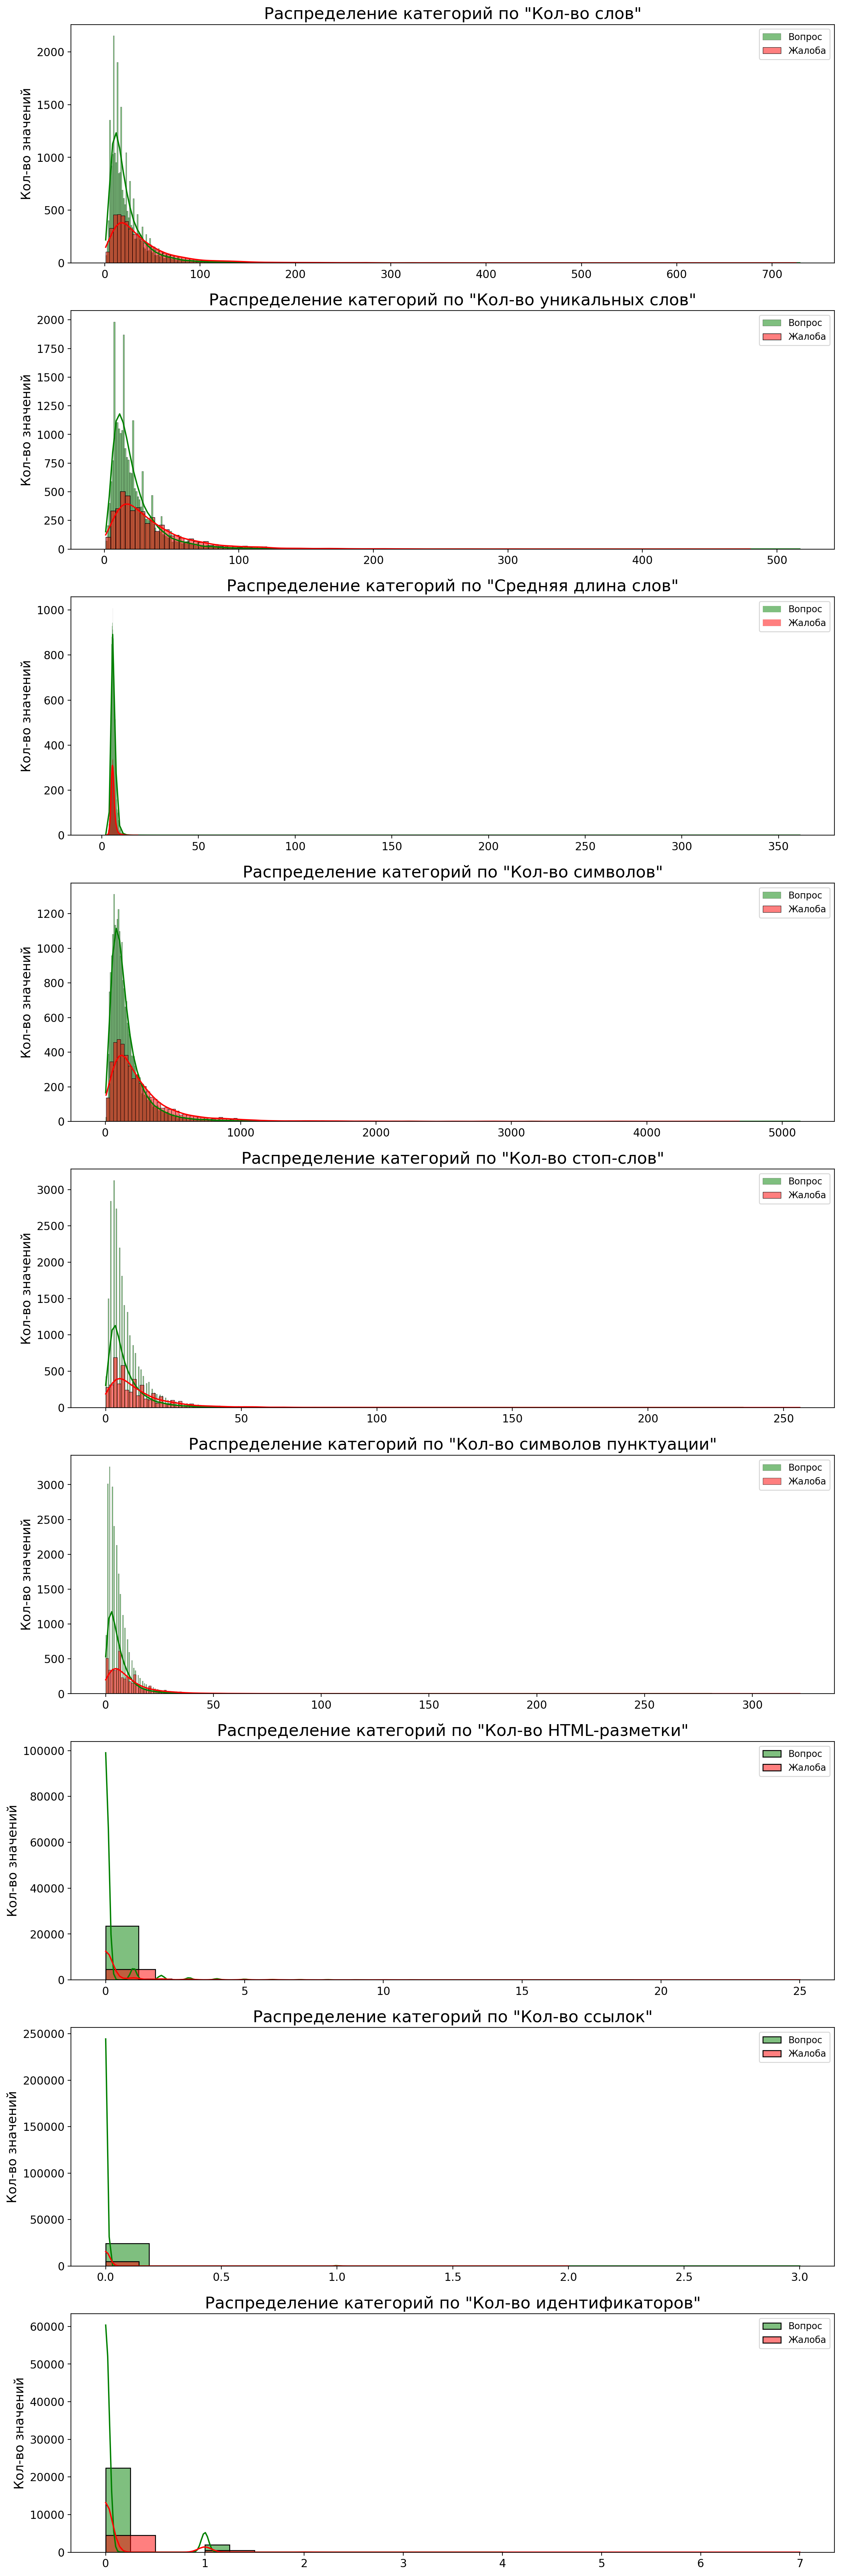

In [ ]:
METAFEATURES = ['Кол-во слов', 'Кол-во уникальных слов', 'Средняя длина слов',
                'Кол-во символов', 'Кол-во стоп-слов', 'Кол-во символов пунктуации',
                'Кол-во HTML-разметки', 'Кол-во ссылок', 'Кол-во идентификаторов']
COMPLAINT_TEXT = df['Категория'] == 'Жалоба'

fig, ax = plt.subplots(nrows=len(METAFEATURES), figsize=(15, 50), dpi=200)

for i, feature in enumerate(METAFEATURES):
    sns.histplot(df.loc[~COMPLAINT_TEXT][feature], label='Вопрос',
                 ax=ax[i], color='green', kde=True)
    sns.histplot(df.loc[COMPLAINT_TEXT][feature], label='Жалоба',
                 ax=ax[i], color='red', kde=True)
    ax[i].set_xlabel('')
    ax[i].set_ylabel('Кол-во значений', fontsize=14)
    ax[i].tick_params(axis='x', labelsize=12)
    ax[i].tick_params(axis='y', labelsize=12)
    ax[i].legend()
    ax[i].set_title(f'Распределение категорий по "{feature}"',
                    fontsize=18)

plt.show()

Все метапризнаки содержат информацию о классах, но некоторые из них недостаточно хороши. Например "Кол-во HTML-разметки", "Кол-во ссылок" и "Кол-во идентификаторов"

С другой стороны, "Кол-во слов", "Кол-во уникальных слов", "Средняя длина слов", "Кол-во символов", "Кол-во стоп-слов", "Кол-во символов пунктуации" имеют разные распределения для текстов с жалобами и вопросами. Дальше эти признаки могут быть полезны в модели.

## 1.6. N-граммы

In [ ]:
# Создадим униграммы, биграммы и триграммы

def generate_ngrams(text: str, n_gram: int=1) -> list:
  """
  Функция создаёт n-граммы.

  Аргументы:
  text - текст;
  n-gram - количество слов из которых будет состоять n-грамма.
  Результат:
  Список n-грамм.
  """

  token = [token for token in text.lower().split(' ') if token != '' if token not in STOPWORDS]
  ngrams = zip(*[token[i:] for i in range(n_gram)])
  return [' '.join(ngram) for ngram in ngrams]

N = 100

# Униграммы
complaint_unigrams = defaultdict(int)
question_unigrams = defaultdict(int)

for text in df[COMPLAINT_TEXT]['Текст']:
  for word in generate_ngrams(text):
    complaint_unigrams[word] += 1
        
for text in df[~COMPLAINT_TEXT]['Текст']:
  for word in generate_ngrams(text):
    question_unigrams[word] += 1
        
df_complaint_unigrams = pd.DataFrame(
    sorted(complaint_unigrams.items(), key=lambda x: x[1])[::-1])
df_question_unigrams = pd.DataFrame(
    sorted(question_unigrams.items(), key=lambda x: x[1])[::-1])

# Биграммы
complaint_bigrams = defaultdict(int)
question_bigrams = defaultdict(int)

for text in df[COMPLAINT_TEXT]['Текст']:
  for word in generate_ngrams(text, n_gram=2):
    complaint_bigrams[word] += 1
        
for text in df[~COMPLAINT_TEXT]['Текст']:
  for word in generate_ngrams(text, n_gram=2):
    question_bigrams[word] += 1
        
df_complaint_bigrams = pd.DataFrame(sorted(complaint_bigrams.items(), key=lambda x: x[1])[::-1])
df_question_bigrams = pd.DataFrame(sorted(question_bigrams.items(), key=lambda x: x[1])[::-1])

# Триграммы
complaint_trigrams = defaultdict(int)
question_trigrams = defaultdict(int)

for text in df[COMPLAINT_TEXT]['Текст']:
  for word in generate_ngrams(text, n_gram=3):
    complaint_trigrams[word] += 1
        
for text in df[~COMPLAINT_TEXT]['Текст']:
  for word in generate_ngrams(text, n_gram=3):
    question_trigrams[word] += 1
        
df_complaint_trigrams = pd.DataFrame(sorted(complaint_trigrams.items(), key=lambda x: x[1])[::-1])
df_question_trigrams = pd.DataFrame(sorted(question_trigrams.items(), key=lambda x: x[1])[::-1])

### 1.6.1. Униграммы

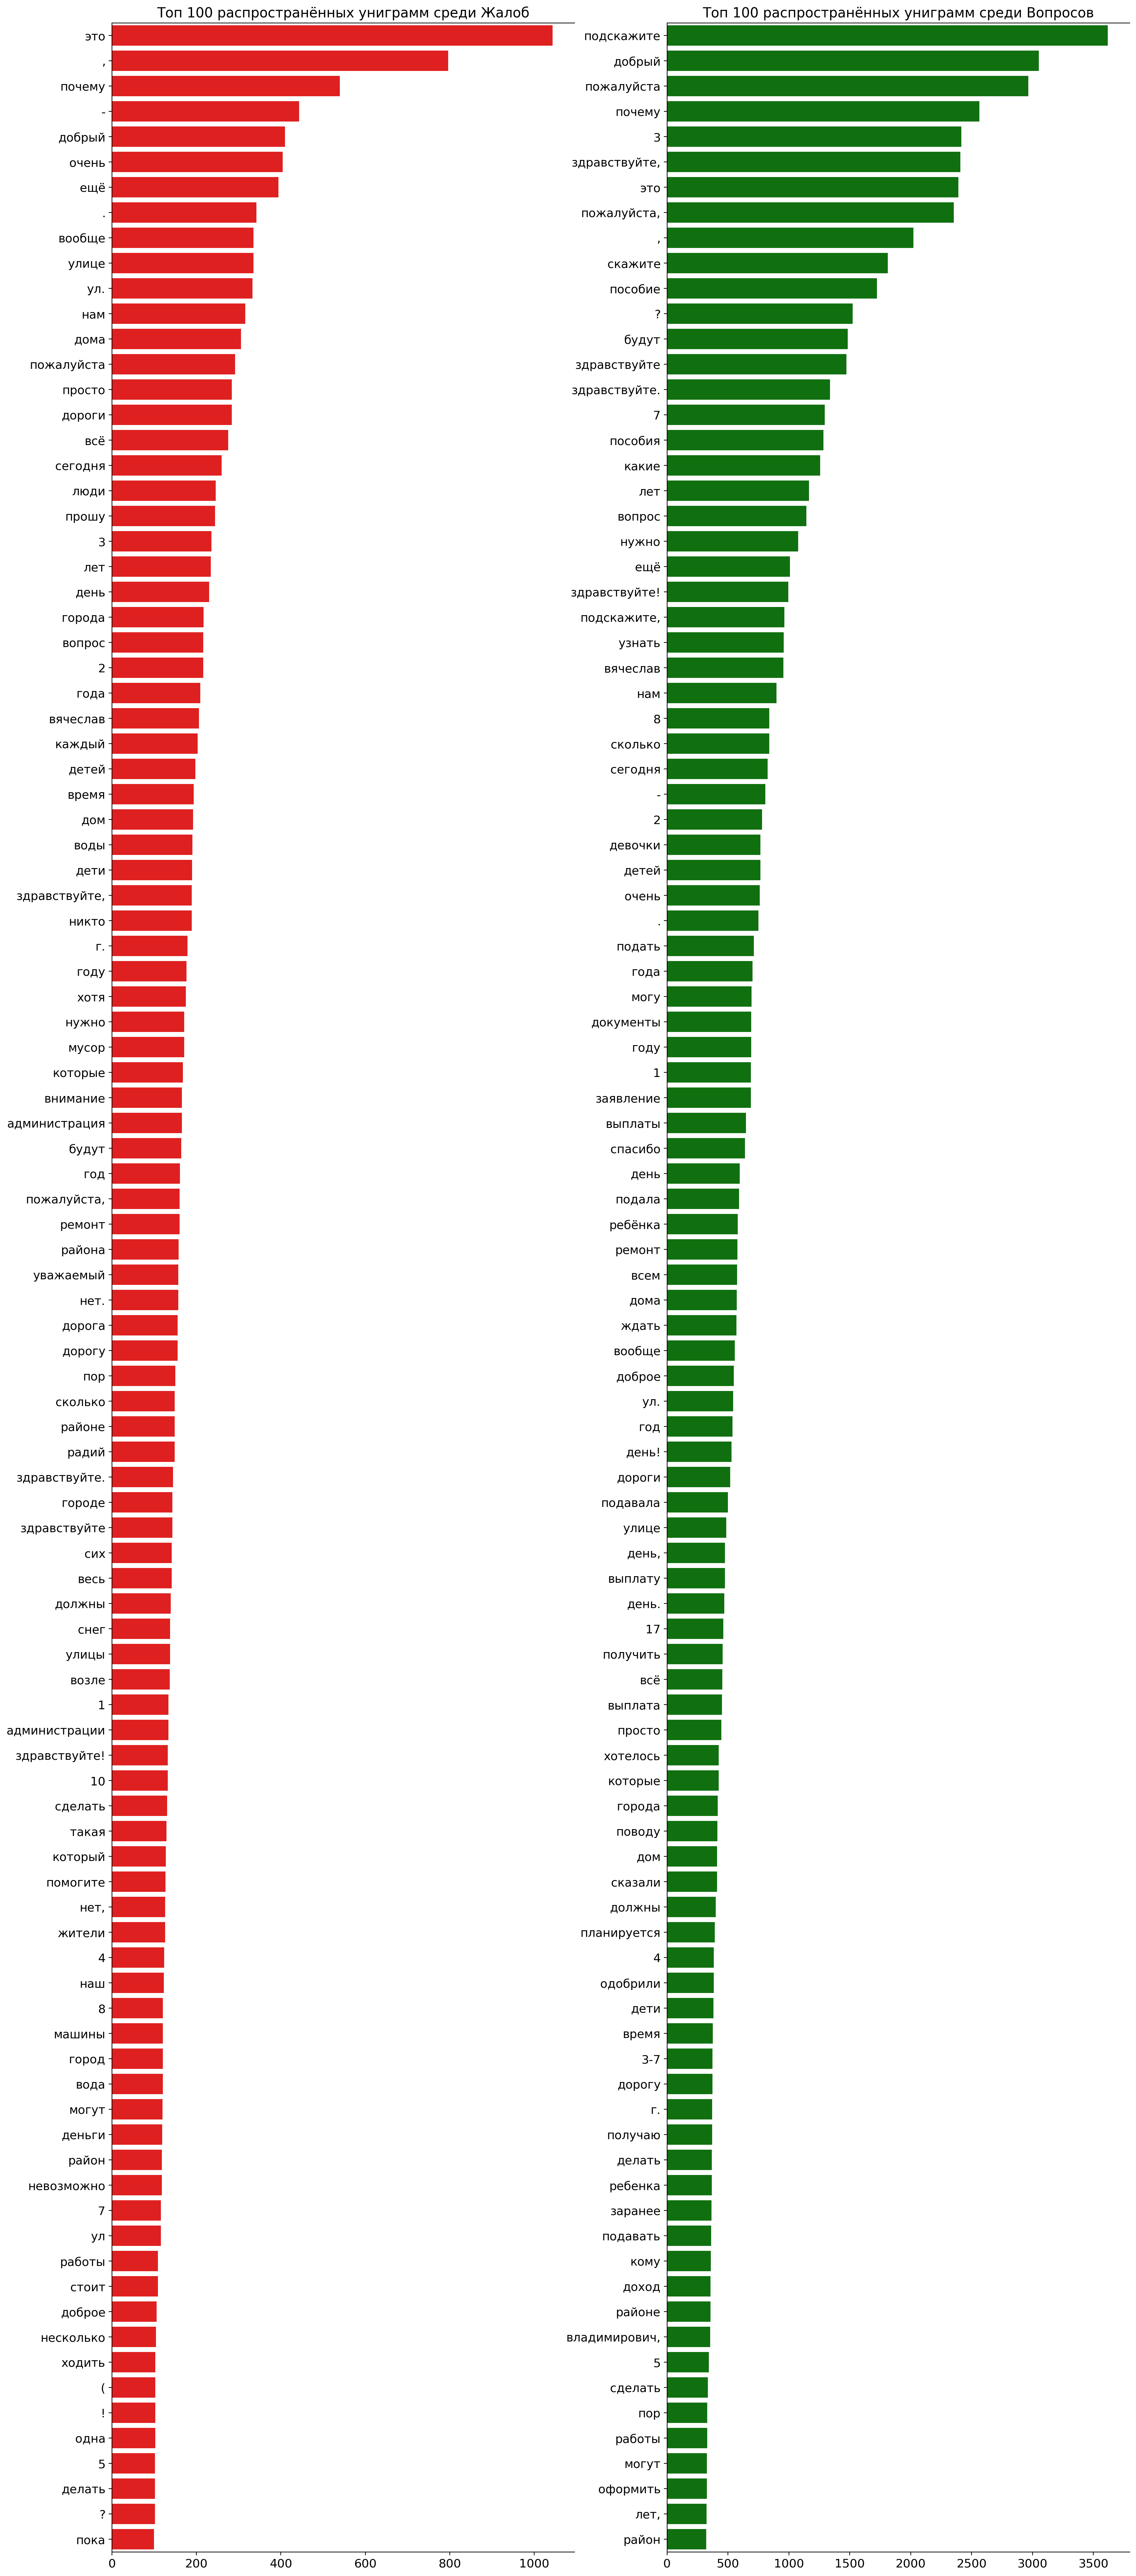

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(20, 50), dpi=200)

sns.barplot(y=df_complaint_unigrams[0].values[:N],
            x=df_complaint_unigrams[1].values[:N],
            ax=axes[0], color='red')
sns.barplot(y=df_question_unigrams[0].values[:N],
            x=df_question_unigrams[1].values[:N],
            ax=axes[1], color='green')

for i in range(2):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=13)
    axes[i].tick_params(axis='y', labelsize=13)

axes[0].set_title(f'Топ {N} распространённых униграмм среди Жалоб', fontsize=15)
axes[1].set_title(f'Топ {N} распространённых униграмм среди Вопросов', fontsize=15)

plt.show()

Наиболее распространенные униграммы, существующие в обоих категориях - это знаки препинания, стоп-слова и числа. Их лучше очистить перед моделированием, так как они не очень информативны.

В униграммах, к сожалению, особо не наблюдаются слова, которые характерно отличали бы жалобу от вопроса.

### 1.6.2. Биграммы

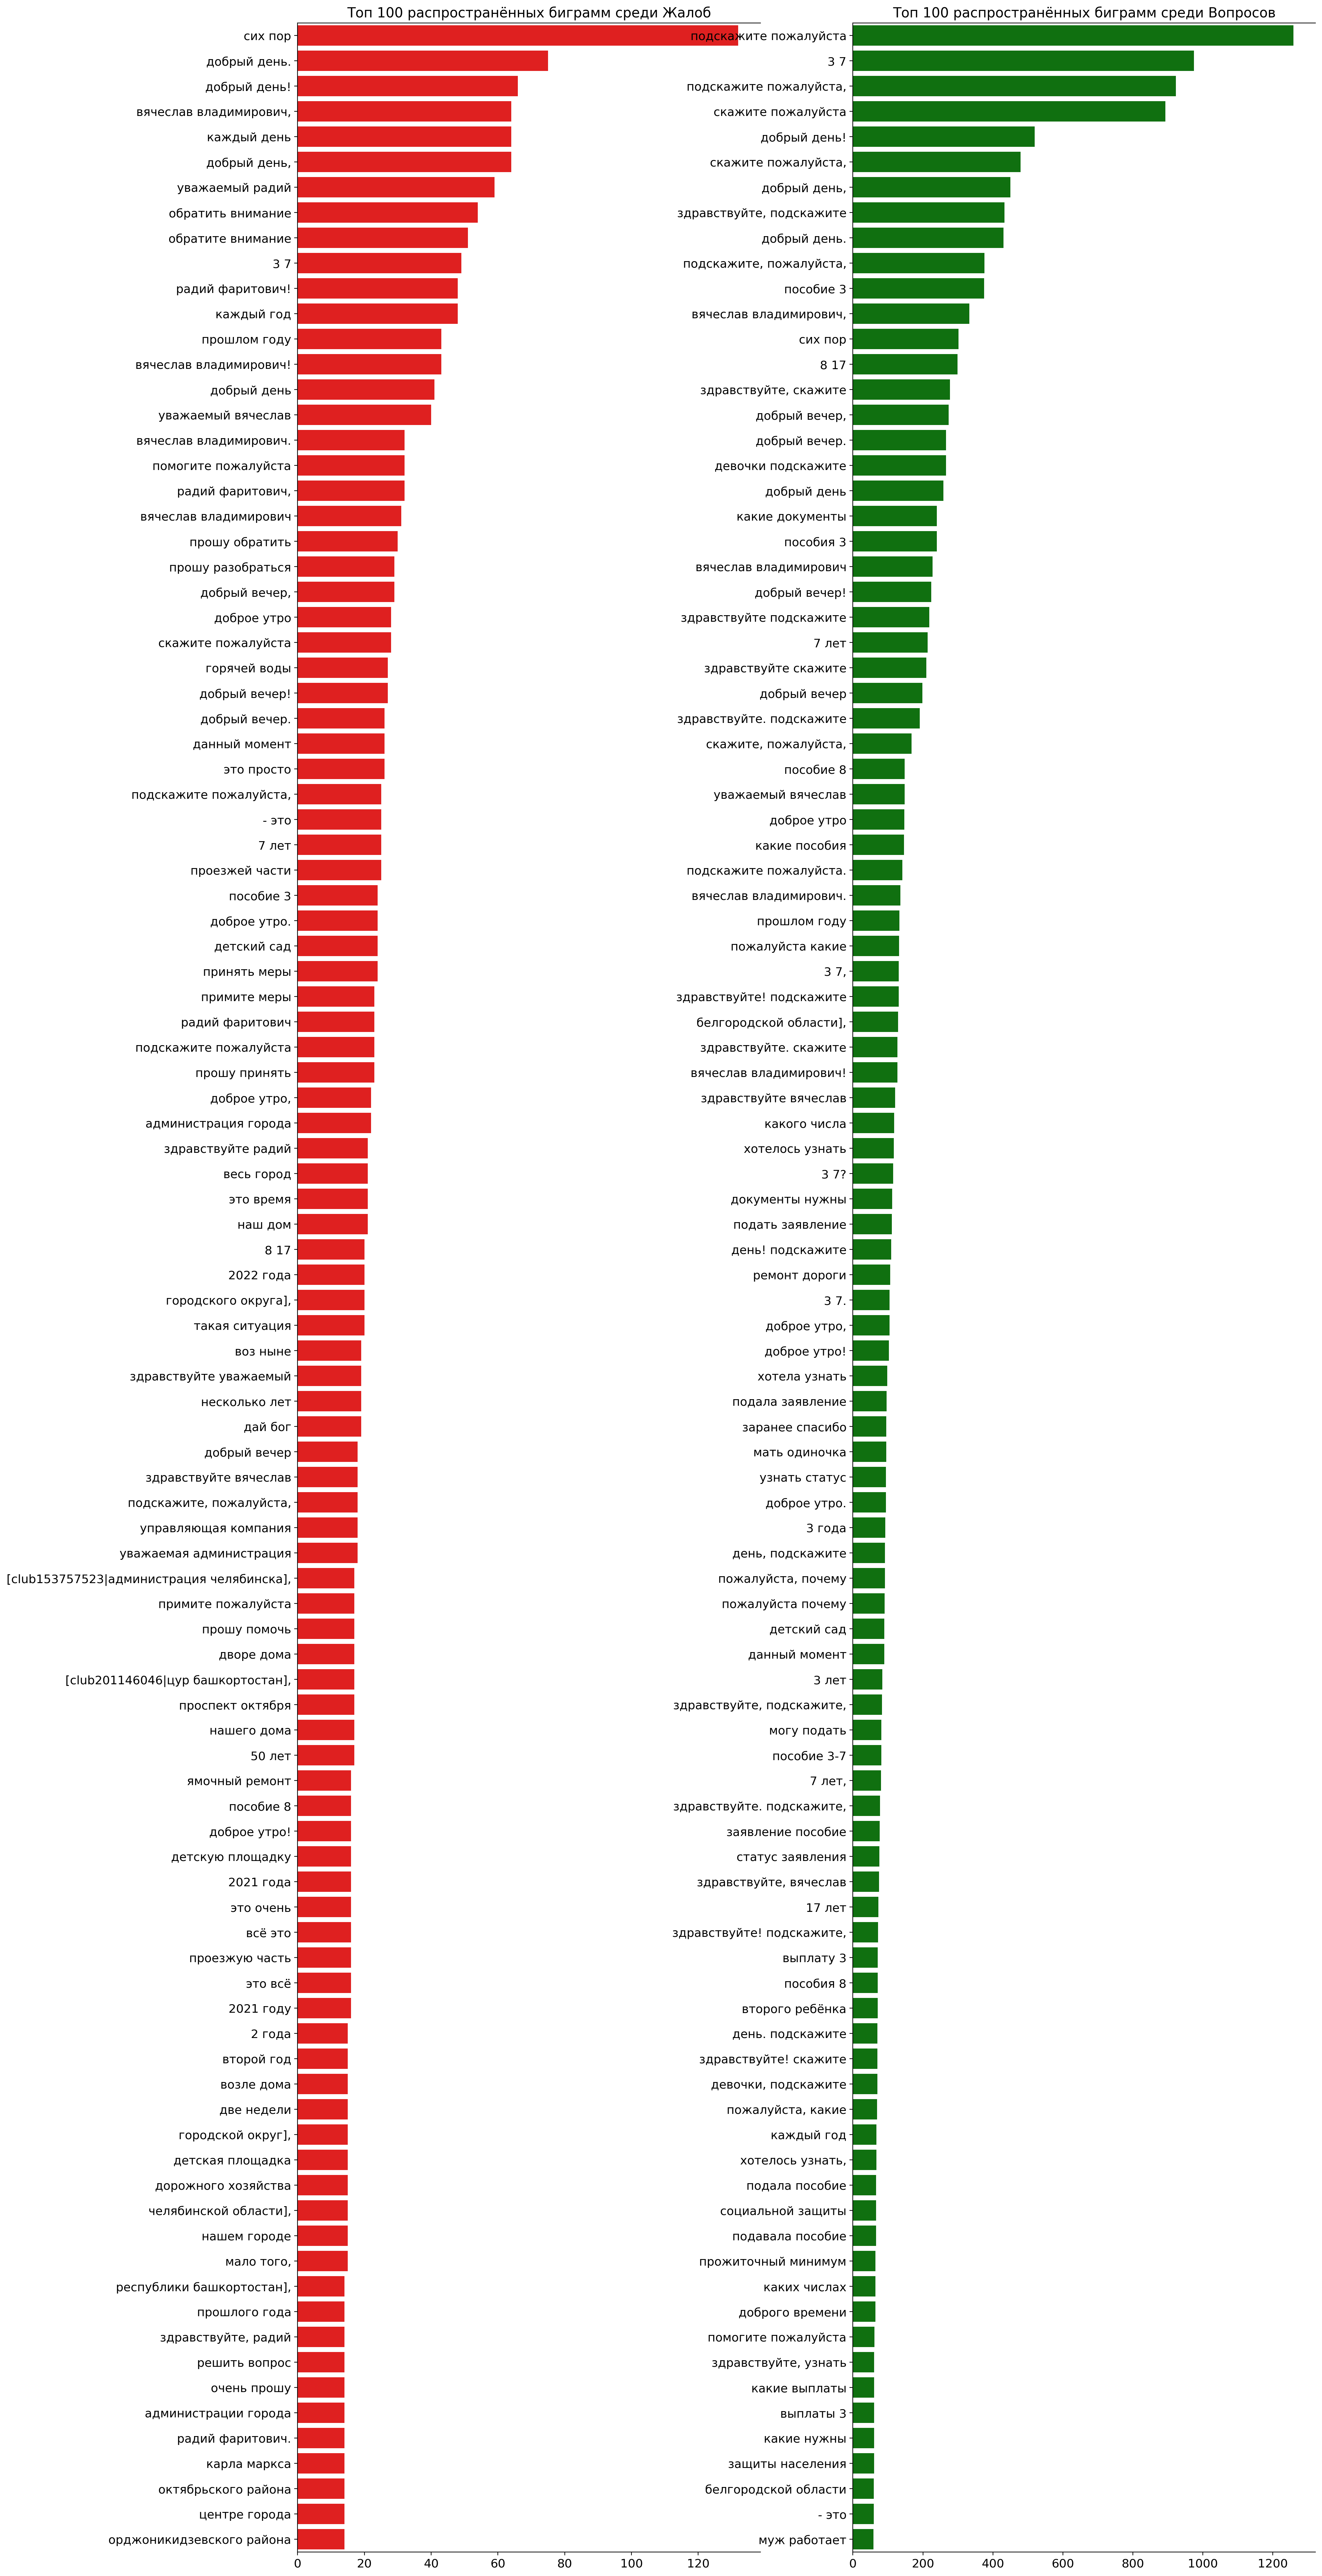

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(20, 50), dpi=200)

sns.barplot(y=df_complaint_bigrams[0].values[:N], 
            x=df_complaint_bigrams[1].values[:N],
            ax=axes[0], color='red')
sns.barplot(y=df_question_bigrams[0].values[:N],
            x=df_question_bigrams[1].values[:N],
            ax=axes[1], color='green')

for i in range(2):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=13)
    axes[i].tick_params(axis='y', labelsize=13)

axes[0].set_title(f'Топ {N} распространённых биграмм среди Жалоб', fontsize=15)
axes[1].set_title(f'Топ {N} распространённых биграмм среди Вопросов', fontsize=15)

plt.show()

В обоих категориях стало меньше общих биграмм, потому что контекст стал понятней.

Наиболее распространенные биграммы в текстах с жалобами дают больше информации о жалобах, чем униграммы, но в словах необходимо убрать знаки препинания.

Наиболее распространенные биграммы в текстах с вопросами в основном встречаются фразы приветствия и любезности, они также содержат много знаков препинания. Эти знаки препинания также должны быть удалены.

### 1.6.3. Триграммы

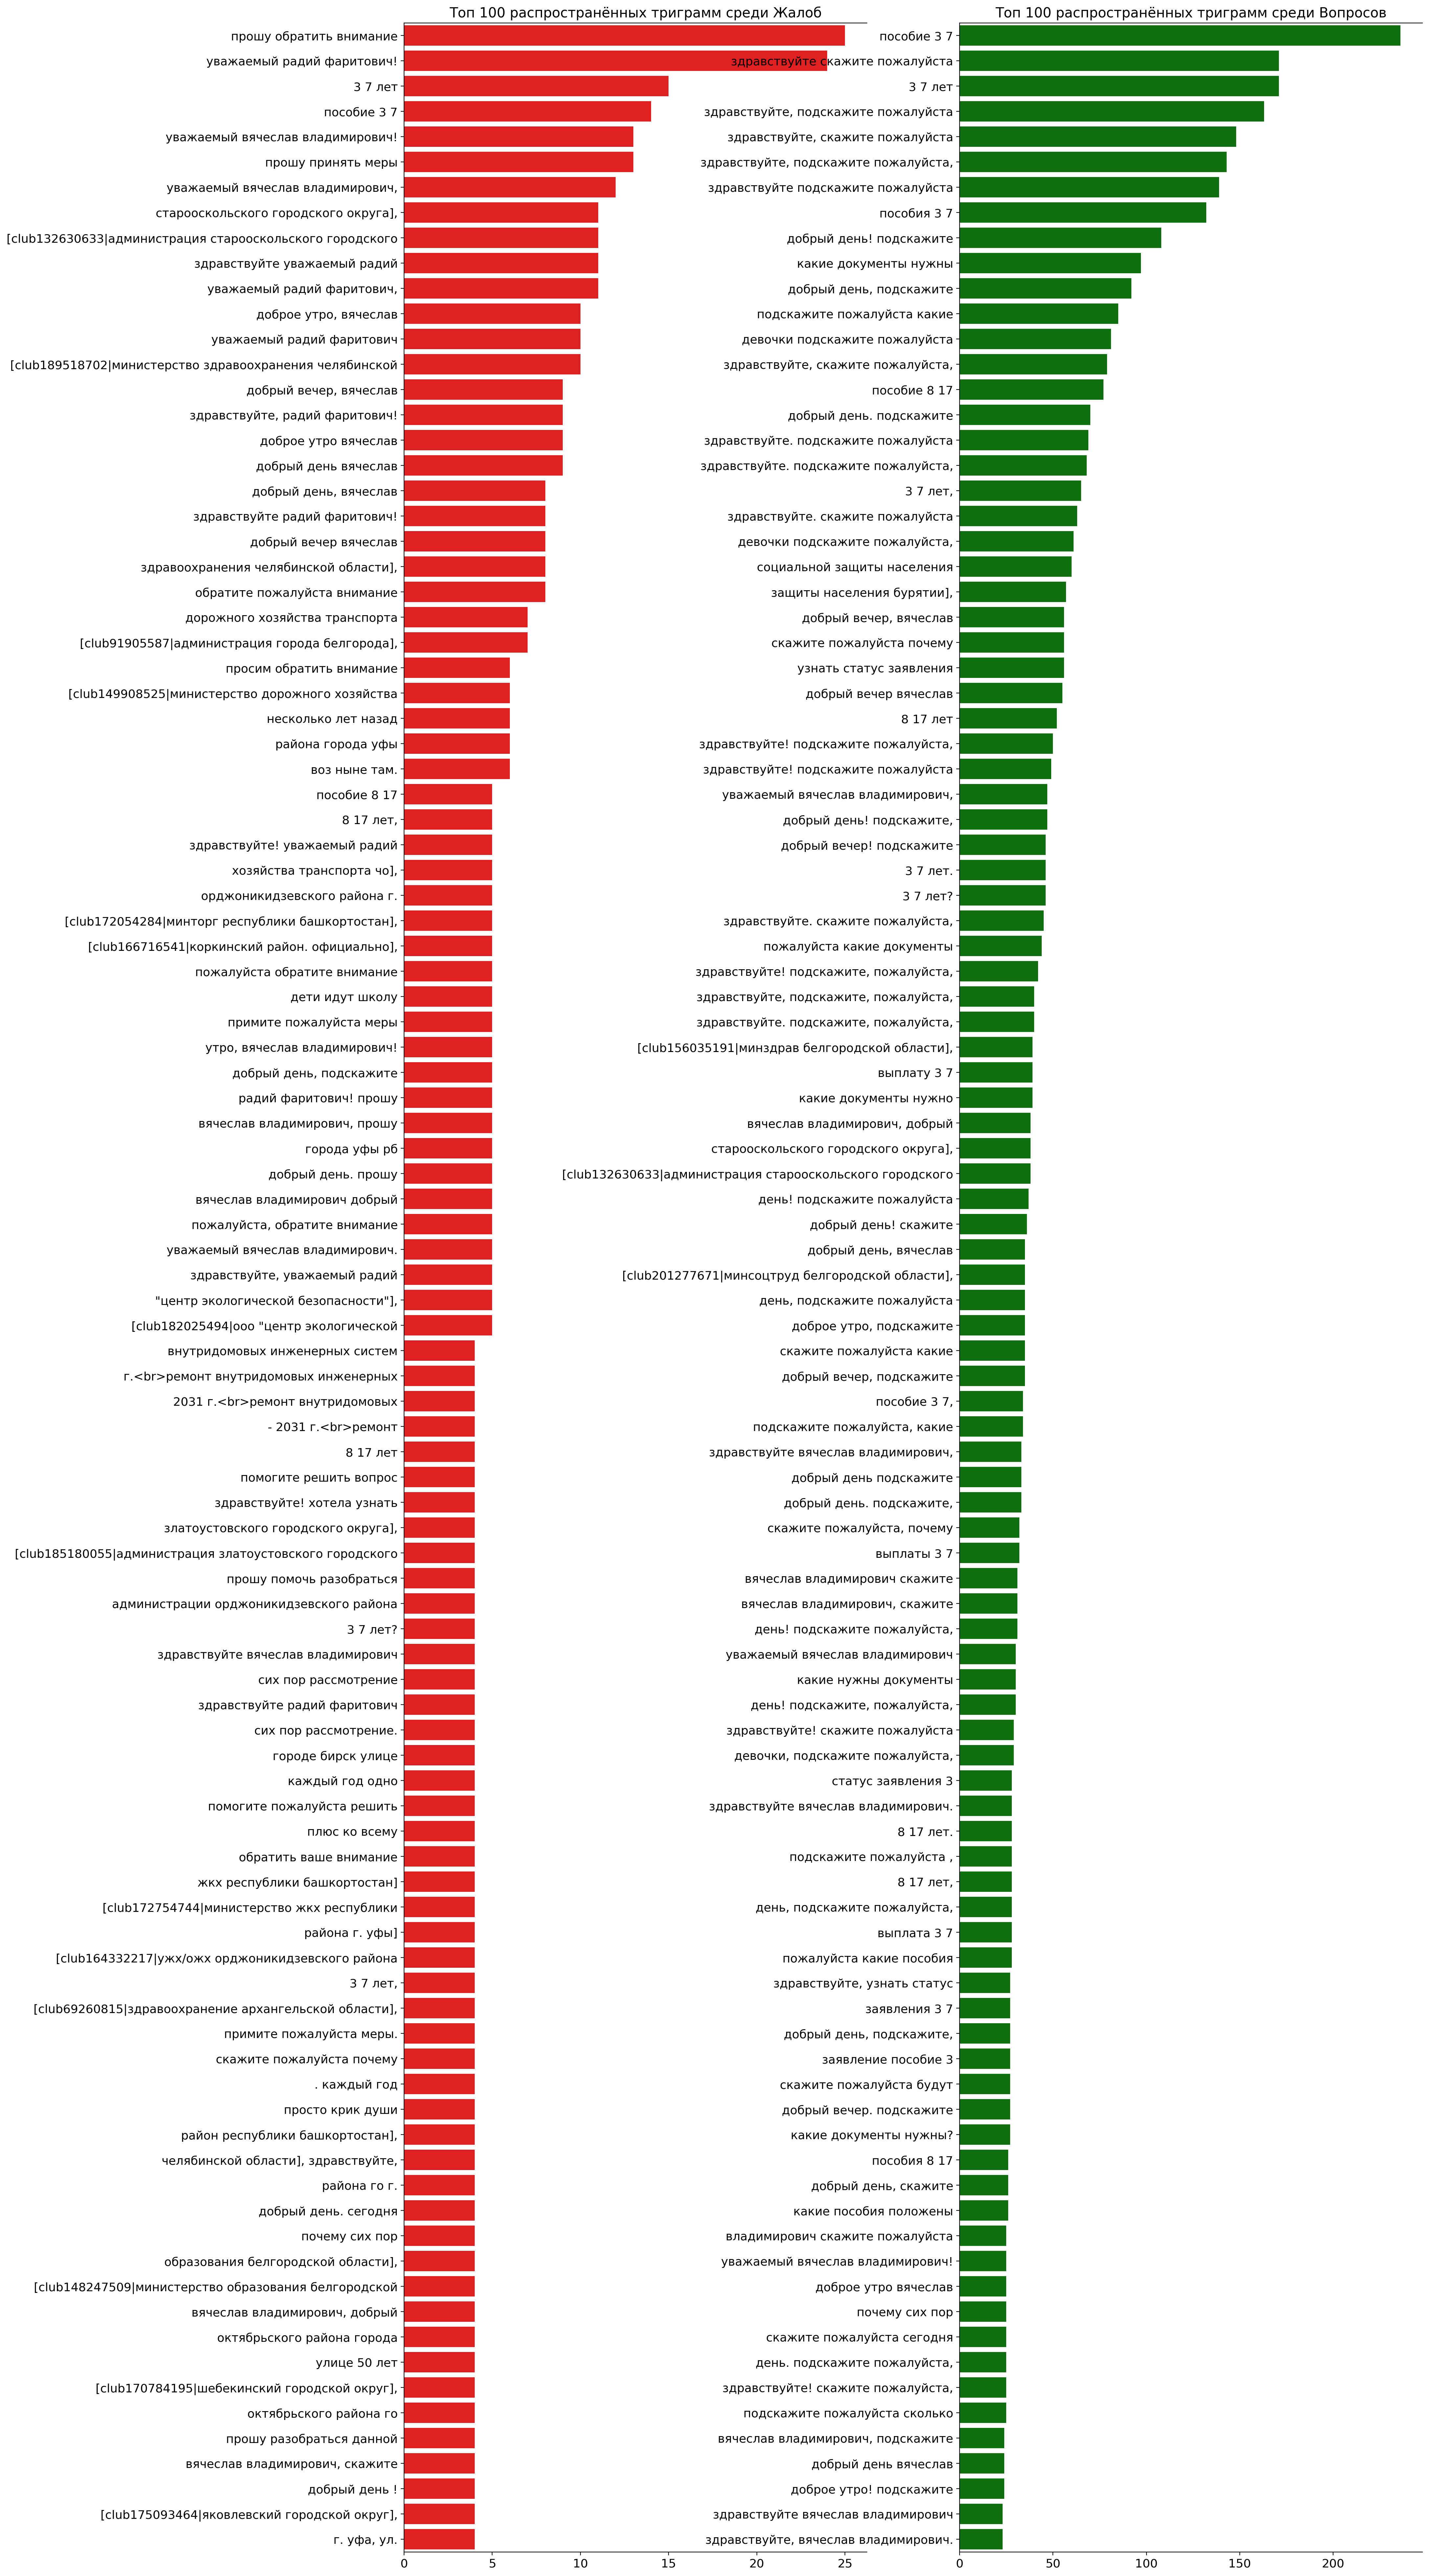

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(20, 50), dpi=200)

sns.barplot(y=df_complaint_trigrams[0].values[:N], 
            x=df_complaint_trigrams[1].values[:N],
            ax=axes[0], color='red')
sns.barplot(y=df_question_trigrams[0].values[:N],
            x=df_question_trigrams[1].values[:N],
            ax=axes[1], color='green')

for i in range(2):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=13)
    axes[i].tick_params(axis='y', labelsize=13)

axes[0].set_title(f'Топ {N} распространённых триграмм среди Жалоб', fontsize=15)
axes[1].set_title(f'Топ {N} распространённых триграмм среди Вопросов', fontsize=15)

plt.show()

В обоих категориях стало также меньше общих триграмм, потому что контекст стал понятнее.

Наиболее распространенные триграммы в текстах с жалобами. Они дают много информации о жалобах, но могут не давать никакой дополнительной информации вместе с биграммами.

Наиболее распространенные триграммы в текстах с вопросами, также очень похожи на биграммы и содержат даже больше знаков препинания.

# 2. Предобработка данных

## 2.0. Задел на будущее

В прошлой главе было создано много весьма полезных признаков, но на данный момент, не хватает времени на реализацию их потенциала. Поэтому эта подглава посвящена удалению этих признаков, в качестве оптимизации, но с заделом на будущее, когда можно будет снова вернуться сюда и отменить их удаление.

In [ ]:
df.drop(columns=['Месяц', 'Час', 'Кол-во слов', 'Кол-во уникальных слов',
                 'Средняя длина слов', 'Кол-во символов', 'Кол-во стоп-слов',
                 'Кол-во символов пунктуации', 'Кол-во HTML-разметки', 
                 'Кол-во ссылок', 'Кол-во идентификаторов'],
        inplace=True)

## 2.1. Оценка предобученных эмбеддингов GloVe и FastText

Для того, чтобы сравнить текст до очистки и после, загрузим уже предобученные эмбеддинги GloVe и FastText и оценим, насколько они покрывают слова в тексте.

In [ ]:
%%time

glove_embeddings = Navec.load('/content/navec_hudlit_v1_12B_500K_300d_100q.tar')

fasttext_embeddings = fasttext.util.download_model('ru', if_exists='ignore')
fasttext_embeddings = fasttext.load_model('cc.ru.300.bin')

CPU times: user 19min 43s, sys: 1min 41s, total: 21min 25s
Wall time: 24min 6s


In [ ]:
# Напишем для этой задачи соответсвующие функции. Одна создаёт словарь,
# другая оценивает покрытие эмбеддингами словаря и текстов датасета.

def build_vocab(X):
    
    texts = X.apply(lambda s: s.split()).values      
    vocab = {}
    
    for text in texts:
        for word in text:
            try:
                vocab[word] += 1
            except KeyError:
                vocab[word] = 1                
    return vocab

def check_embeddings_coverage(X, embeddings):
    
    vocab = build_vocab(X)    
    
    covered = {}
    oov = {}    
    n_covered = 0
    n_oov = 0
    
    for word in vocab:
        try:
            covered[word] = embeddings[word]
            n_covered += vocab[word]
        except:
            oov[word] = vocab[word]
            n_oov += vocab[word]
            
    vocab_coverage = len(covered) / len(vocab)
    text_coverage = (n_covered / (n_covered + n_oov))
    
    sorted_oov = sorted(oov.items(), key=operator.itemgetter(1))[::-1]
    return sorted_oov, vocab_coverage, text_coverage

glove_oov, glove_vocab_coverage, glove_text_coverage = (
    check_embeddings_coverage(df['Текст'], glove_embeddings))
print(
    ('GloVe эмбеддинги покрывают {:.2%} словаря и {:.2%} текстов датасета'
    .format(glove_vocab_coverage, glove_text_coverage)))


fasttext_oov, fasttext_vocab_coverage, fasttext_text_coverage = (
    check_embeddings_coverage(df['Текст'], fasttext_embeddings))
print(
    ('FastText эмбеддинги покрывают {:.2%} словаря и {:.2%} текстов датасета'
    .format(fasttext_vocab_coverage, fasttext_text_coverage)))

GloVe эмбеддинги покрывают 26.46% словаря и 65.59% текстов датасета
FastText эмбеддинги покрывают 100.00% словаря и 100.00% текстов датасета


Слова на пересечении словаря и эмбеддингов хранятся в covered вместе с их количеством. Слова в словаре, которых нет в эмбеддингах, хранятся в oov вместе с их количеством. n_covered и n_oov — это общее количество подсчетов, которые используются для расчёта процента покрытия.

Эмбеддинги GloVe имеют меньшее покрытие, как по словарю, так и по всем текстам датасета, чем FastText. FastText же, имеет полное покрытие как словаря, так и текста датасета, причем это без чистки текста, что весьма странно, так как есть явно такие слова, которые он, скорей всего, никогда не видел. Например, идентификаторы. Но если даже это реальные цифры, то это не значит, что подход GloVe хуже, просто не нашёлся лучший русскоязычный вариант. Поиск его занимает много времени, поэтому оставим пока такой, какой есть.

С другой стороны, благодаря GloVe, скорей всего, мы сможем отследить динамику после очистки текстов.

## 2.2. Очистка текста

Как мы узнали в подглаве 1.5., помимо всяких стоп-слов, шум ещё привносят html-разметки, ссылки и идентификаторы. Также, шум могут нести различные цифры и символы английского языка (были названия видеофайлов, номера СНИЛС-ов и тд.), а также знаки пунтктуации. Насчёт последних, следует сказать, что не хотелось бы исключать восклицательные и вопросительные знаки, так как именно они способны окрасить предложения должным образом, который свойствен для жалоб и предложений.

In [ ]:
def cleaning_text(text):
  # Переведём текст в нижний регистр
  text = text.lower()

  # Удаление html-разметки
  text = re.sub('<.*?>', '', text)

  # Удаление ссылок
  text = re.sub(r'https?:\/\/t.co\/[A-Za-z0-9]+', '', text)

  # Удаление идентификаторов
  text = re.sub('\[(.*?)\]', '', text)

  # Удаление цифр
  text = re.sub('\d', '', text)

  # Удаление латинских символов
  text = re.sub('[a-z]', '', text)

  # Удаление специальных знаков и знаков пунктуаций (за исключением "!?")
  punctuations = '@#№$%^&*/|\\<>=-+_`~±§()[]{}"\':;,.'
  for p in punctuations:
    text = text.replace(p, ' ')
  
  # Отделим восклицательные и вопросительные знаки от слов
  text.replace('!', ' ! ')
  text.replace('?', ' ? ')

  # Удаление лишних пробелов
  text = text.replace(r'      ', ' ')
  text = text.replace(r'     ', ' ')
  text = text.replace(r'    ', ' ')
  text = text.replace(r'   ', ' ')
  text = text.replace(r'  ', ' ')

  # Удаляем стоп-слова
  text = [w for w in text.split() if w  not in STOPWORDS]

  # Лемматизация текста
  morph = pymorphy2.MorphAnalyzer()
  text = ' '.join([morph.parse(w)[0].normal_form for w in text])

  return text

In [ ]:
# Применяем функцию cleaning_text() к тексту датасета

%%time

df['Очищенный_текст'] = df['Текст'].apply(lambda x: cleaning_text(x))

CPU times: user 47min 42s, sys: 7min 18s, total: 55min
Wall time: 57min 30s


In [ ]:
# Могли получиться объекты с пустыми текстами. Удаляем их

len_before = len(df)
df.drop(index=df[df['Очищенный_текст'] == ''].index, inplace=True)
len_after = len(df)

print(
    ('Кол-во объектов без текста, после чистки: {}'
    .format(len_before - len_after)))

Кол-во объектов без текста, после чистки: 9


### 2.2.1. Checkpoint: очищенные данные

In [ ]:
# Сохраняем датасет как файл, так как операция очистки занимает около часа.
# Нужно иметь возможность быстро вернуться в случае чего.

df.to_csv('/content/data_cleaned.csv')

## 2.3. Оценка результатов очистки текста

In [ ]:
print(
    ('До чистки: GloVe эмбеддинги покрывают {:.2%} словаря и {:.2%} текстов датасета'
    .format(glove_vocab_coverage, glove_text_coverage)))
print(
    ('До чистки: FastText эмбеддинги покрывают {:.2%} словаря и {:.2%} текстов датасета\n'
    .format(fasttext_vocab_coverage, fasttext_text_coverage)))

glove_oov, glove_vocab_coverage, glove_text_coverage = (
    check_embeddings_coverage(df['Очищенный_текст'], glove_embeddings))
print(
    ('После чистки: GloVe эмбеддинги покрывают {:.2%} словаря и {:.2%} текстов датасета'
    .format(glove_vocab_coverage, glove_text_coverage)))

fasttext_oov, fasttext_vocab_coverage, fasttext_text_coverage = (
    check_embeddings_coverage(df['Очищенный_текст'], fasttext_embeddings))
print(
    ('После чистки: FastText эмбеддинги покрывают {:.2%} словаря и {:.2%} текстов датасета'
    .format(fasttext_vocab_coverage, fasttext_text_coverage)))

До чистки: GloVe эмбеддинги покрывают 26.46% словаря и 65.59% текстов датасета
До чистки: FastText эмбеддинги покрывают 100.00% словаря и 100.00% текстов датасета

После чистки: GloVe эмбеддинги покрывают 37.21% словаря и 87.44% текстов датасета
После чистки: FastText эмбеддинги покрывают 100.00% словаря и 100.00% текстов датасета


Как мы и предполагали, после очистки текста есть динамика у GloVe. Покрытие словарёв стало на 9% больше, а текстов датасета на 20%.

После очистки текста, удалим glove_embeddings и fasttext_embeddings, а также их производных, так как они занимают много памяти в ОЗУ, а также собирается много мусора.

In [ ]:
del glove_oov, glove_vocab_coverage, glove_text_coverage
del fasttext_oov, fasttext_vocab_coverage, fasttext_text_coverage
del len_after, len_before
gc.collect()

178784

### 2.3.1. Start from Checkpoint: очищенные данные

In [ ]:
# Загрузка библиотеки Transformers

!pip --quiet install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 75.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 28.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 82.1 MB/s eta 0:00:00


In [ ]:
import gc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import StratifiedKFold

from transformers import AutoTokenizer
from transformers import TFBertForSequenceClassification

import tensorflow as tf
from tensorflow import keras
from keras.optimizers import SGD, Adam
from keras.layers import Dense, Input
from keras.models import Model
from keras.callbacks import Callback

In [ ]:
# Скачиваем предобработанный ранее датасет

# !gdown --quiet something url

df = pd.read_csv('/content/data_cleaned.csv').set_index('Unnamed: 0')

## 2.4. Разделение данных на тренировочную и тестовую выборки

In [ ]:
# Заменим вопросы на 0, а жалобы на 1, так как дальше будут возникать
# проблемы с типом данных str в графе вычислений

df['Категория'] = df['Категория'].replace({'Вопрос': 0, 'Жалоба': 1})

Поскольку данные не сбалансированы по классам, то необходимо их разделить со стратификацией.

In [ ]:
df_train, df_test, y_train, y_test = train_test_split(
    df.drop(columns='Категория'), df['Категория'], 
    test_size=0.3, random_state=14, stratify=df['Категория'])

df_train['Категория'] = y_train
df_test['Категория'] = y_test

del y_train, y_test
gc.collect()

192

In [ ]:
# Поскольку индекс у объектов был просто нумерацией и не содержал в себе
# никакой полезной информации, то мы сбросим его и заново пронумеруем объекты,
# так как прежний, неупорядоченный индекс создаст проблемы в дальнейшем.
# Если после классификации нам понадобится вернуть объектам прежние индексы, то
# мы всегда можем извлечь их по старому тексту, который мы не удаляли из df.

df_train.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

# 3. Создание модели

## 3.1. Кросс-валидация

Тексты по каждой теме есть как в тренировочном, так и в тестовом наборе данных, и мы их взяли из одной и той же выборки. Чтобы воспроизвести тот же метод разделения, используется StratifiedKFold, затем передается тема в качестве y, из-за этого стратификация выполняется на основе признака "Тема". shuffle имеет значение True для дополнительного разнообразия тренировок. В обоих фолдах есть тексты из каждой темы в тренировочных и тестовых наборах, которые можно увидеть снизу.

In [ ]:
K = 2
skf = StratifiedKFold(n_splits=K, random_state=1337, shuffle=True)

COMPLAINT = df_train['Категория'] == 1
print('Размерность тренировочного набора: {}'.format(df_train.shape))
print(
    ('Кол-во уникальных тем тренировочного набора: {}'
    .format(df_train['Тема'].nunique())))
print(
    ('Отношение классов тренировочного набора: {} (Жалоба) / {} (Вопрос)'
    .format(df_train[COMPLAINT]['Категория'].count(),
            df_train[~COMPLAINT]['Категория'].count())))

for fold, (trn_idx, val_idx) in enumerate(skf.split(df_train['Очищенный_текст'], df_train['Категория']), 1):
    print(
        ('\nFold {} Размерность тренировочного набора: {} - Размерность валидационного набора: = {}'
        .format(fold, df_train.loc[trn_idx, 'Очищенный_текст'].shape,
                df_train.loc[val_idx, 'Очищенный_текст'].shape)))
    print(
        ('Fold {} Кол-во уникальных тем тренировочного набора: {} - Кол-во уникальных тем валидационного набора: {}'
        .format(fold, df_train.loc[trn_idx, 'Тема'].nunique(),
                df_train.loc[val_idx, 'Тема'].nunique())))    

Размерность тренировочного набора: (20535, 6)
Кол-во уникальных тем тренировочного набора: 31
Отношение классов тренировочного набора: 3471 (Жалоба) / 17064 (Вопрос)

Fold 1 Размерность тренировочного набора: (10267,) - Размерность валидационного набора: = (10268,)
Fold 1 Кол-во уникальных тем тренировочного набора: 31 - Кол-во уникальных тем валидационного набора: 31

Fold 2 Размерность тренировочного набора: (10268,) - Размерность валидационного набора: = (10267,)
Fold 2 Кол-во уникальных тем тренировочного набора: 31 - Кол-во уникальных тем валидационного набора: 31


*Примечание:

Оказалось, важно соблюсти разницу между количеством уникальных тем тренировочного и валидационного наборов. Причем в разных фолдах. 

Долго не мог понять, почему не работают должным образом метрики во время обучения, а оказалось всё дело в random_state. Я его почти всегда ставлю равным 14. Один раз такое число себя хорошо показало и теперь я только его использую, хоть и понимаю, что это не гарантирует мне прежних результатов. Вот сейчас это число сыграло злую шутку - на random_state=14, все фолды имеют одинаковое кол-во тем как в тренировочном, так и в валидационном наборе. Сменив число на 13, всё сразу стало работать хорошо.

Ох уж этот Бог Рандома. Много часов и вычислительных ресурсов потрачено на всякие глупые проверки...

UPDATE: Даже если будет разное кол-во уникальных тем в тренировочном и валидационном наборе данных (далее "разность") при одном random_state, то не факт, что будет также в следующий раз. В дальнейшем необходимо прописать условие, которое смотрит на наличие разности и меняет random_state, если таковой нет.

## 3.2. Создание функций метрик

Так как в задании не определена метрика, то будем использовать золотую 4-ку: accuracy, precision, recall и f1. В конце посмотрим на результаты по каждой из метрик.

In [ ]:
class ClassificationReport(Callback):
    
    def __init__(self, train_data=(), validation_data=()):
        super(Callback, self).__init__()
        
        self.X_train, self.y_train = train_data
        self.train_precision_scores = []
        self.train_recall_scores = []
        self.train_f1_scores = []
        
        self.X_val, self.y_val = validation_data
        self.val_precision_scores = []
        self.val_recall_scores = []
        self.val_f1_scores = [] 
               
    def on_epoch_end(self, epoch, logs={}):
        train_predictions = np.round(self.model.predict(self.X_train, verbose=0))        
        train_precision = precision_score(self.y_train, train_predictions, average='macro')
        train_recall = recall_score(self.y_train, train_predictions, average='macro')
        train_f1 = f1_score(self.y_train, train_predictions, average='macro')
        self.train_precision_scores.append(train_precision)        
        self.train_recall_scores.append(train_recall)
        self.train_f1_scores.append(train_f1)
        
        val_predictions = np.round(self.model.predict(self.X_val, verbose=0))
        val_precision = precision_score(self.y_val, val_predictions, average='macro')
        val_recall = recall_score(self.y_val, val_predictions, average='macro')
        val_f1 = f1_score(self.y_val, val_predictions, average='macro')
        self.val_precision_scores.append(val_precision)        
        self.val_recall_scores.append(val_recall)        
        self.val_f1_scores.append(val_f1)
        
        print(
            ('\nEpoch: {} - Training Precision: {:.6} - Training Recall: {:.6} - Training F1: {:.6}'
            .format(epoch + 1, train_precision, train_recall, train_f1)))
        print(
            ('Epoch: {} - Validation Precision: {:.6} - Validation Recall: {:.6} - Validation F1: {:.6}'
            .format(epoch + 1, val_precision, val_recall, val_f1)))  

## 3.3. Токенайзер, модель и оптимизатор

В качестве предобученной модели будем использовать ruBERT, руссский аналог BERT. Токенайзер тоже от ruBERT. Перевёдем их сразу для TensorFlow. Для хорошего бейзлайна не плохо, а для исследований нужно время.

С оптимизаторами можно много возиться, но зачастую, хорошее решение это Adam или SGD. Последний же нуждается в тонкой и сложной настройке, но может показывать результаты лучше чем Adam. Можно начать с Adam, а потом уже эксперементировать с SGD, если хватит времени (и сил).

*Примечание: Если выбрать Adam, то возникает такая же проблема с метриками во время обучения как при random_state=14 в кросс-валидации. Хотя сейчас в кросс-валидации стоит random_state=13. Странные дела...

UPDATE: Непонятно в чем причина такого поведения метрик. Есть предположение, что это из-за разделения датасета на тренировку и тест. Изначально, было задано 0.2 тестовых данных, затем 0.3 и ошибки вроде бы стали меньше возникать. Возможно из-за дисбаланса классов было мало жалоб в тестовом наборе и потому возникали ошибки в подсчете метрик. Но если поменять SGD на Adam или изменить значение random_state в кросс_валидации, то ошибки возникают снова, а спустя несколько попыток исчезают. Странные дела...[2].

Ссылка на проблему на stackoverflow: https://stackoverflow.com/a/67394358

In [ ]:
%%time

tokenizer = AutoTokenizer.from_pretrained("DeepPavlov/rubert-base-cased", from_pt=True)
rubert_layer = TFBertForSequenceClassification.from_pretrained('DeepPavlov/rubert-base-cased', from_pt=True)

# optimizer = Adam(learning_rate=3e-4)
optimizer = SGD(learning_rate=1e-4, momentum=0.8)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertForSequenceClassification: ['bert.embeddings.position_ids']
- This IS expected if you are initializing TFBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


CPU times: user 3.54 s, sys: 2.63 s, total: 6.18 s
Wall time: 14 s


## 3.4. Архитектура модели

In [ ]:
class ComplaintDetector:
    
    def __init__(self, bert_layer, tokenizer, optimizer,
                 max_seq_length=128, batch_size=32, epochs=10):
        
        # BERT and Tokenization params
        self.bert_layer = bert_layer
        self.tokenizer = tokenizer
        self.max_seq_length = max_seq_length        
        
        # Learning control params
        self.optimizer = optimizer
        self.batch_size = batch_size
        self.epochs = epochs
        
        self.models = []
        self.scores = {}
        
        
    def encode(self, texts):
                
        all_tokens = []
        all_masks = []
        all_segments = []

        for text in texts:
            text = self.tokenizer.tokenize(text)
            text = text[:self.max_seq_length - 2]
            input_sequence = ['[CLS]'] + text + ['[SEP]']
            pad_len = self.max_seq_length - len(input_sequence)

            tokens = self.tokenizer.convert_tokens_to_ids(input_sequence)
            tokens += [0] * pad_len
            pad_masks = [1] * len(input_sequence) + [0] * pad_len
            segment_ids = [0] * self.max_seq_length

            all_tokens.append(tokens)
            all_masks.append(pad_masks)
            all_segments.append(segment_ids)

        return np.array(all_tokens), np.array(all_masks), np.array(all_segments)
    
    
    def build_model(self):
        
        input_word_ids = Input(shape=(self.max_seq_length,),
                               dtype=tf.int32, name='input_word_ids')
        input_mask = Input(shape=(self.max_seq_length,),
                           dtype=tf.int32, name='input_mask')
        segment_ids = Input(shape=(self.max_seq_length,),
                            dtype=tf.int32, name='segment_ids')    
        
        sequence_output = self.bert_layer([input_word_ids, input_mask, segment_ids])   
        clf_output = sequence_output[0]
        out = Dense(1, activation='sigmoid')(clf_output)
        
        model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
        model.compile(
            loss='binary_crossentropy', optimizer=self.optimizer, metrics=['accuracy'])
        
        return model
    
    
    def train(self, X):
        
        for fold, (trn_idx, val_idx) in enumerate(skf.split(X['Очищенный_текст'], X['Тема'])):
            
            print('\nFold {}\n'.format(fold))
        
            X_trn_encoded = self.encode(X.loc[trn_idx, 'Очищенный_текст'].str.lower())
            y_trn = X.loc[trn_idx, 'Категория']
            X_val_encoded = self.encode(X.loc[val_idx, 'Очищенный_текст'].str.lower())
            y_val = X.loc[val_idx, 'Категория']
        
            # Callbacks
            metrics = ClassificationReport(train_data=(X_trn_encoded, y_trn),
                                           validation_data=(X_val_encoded, y_val))
            
            # Model
            model = self.build_model()        
            model.fit(X_trn_encoded, y_trn, validation_data=(X_val_encoded, y_val),
                      callbacks=[metrics], epochs=self.epochs, batch_size=self.batch_size)
            
            self.models.append(model)
            self.scores[fold] = {
                'train': {
                    'precision': metrics.train_precision_scores,
                    'recall': metrics.train_recall_scores,
                    'f1': metrics.train_f1_scores                    
                },
                'validation': {
                    'precision': metrics.val_precision_scores,
                    'recall': metrics.val_recall_scores,
                    'f1': metrics.val_f1_scores                    
                }
            }
                    
                
    def plot_learning_curve(self):
        
        fig, axes = plt.subplots(nrows=K, ncols=2, figsize=(20, K * 6), dpi=200)
    
        for i in range(K):
            
            # Classification Report curve
            sns.lineplot(x=np.arange(1, self.epochs + 1),
                         y=clf.models[i].history.history['val_accuracy'],
                         ax=axes[i][0], label='val_accuracy')
            sns.lineplot(x=np.arange(1, self.epochs + 1),
                         y=clf.scores[i]['validation']['precision'],
                         ax=axes[i][0], label='val_precision')
            sns.lineplot(x=np.arange(1, self.epochs + 1),
                         y=clf.scores[i]['validation']['recall'],
                         ax=axes[i][0], label='val_recall')
            sns.lineplot(x=np.arange(1, self.epochs + 1),
                         y=clf.scores[i]['validation']['f1'],
                         ax=axes[i][0], label='val_f1')        

            axes[i][0].legend() 
            axes[i][0].set_title('Fold {} Validation Classification Report'.format(i),
                                 fontsize=14)

            # Loss curve
            sns.lineplot(x=np.arange(1, self.epochs + 1),
                         y=clf.models[0].history.history['loss'],
                         ax=axes[i][1], label='train_loss')
            sns.lineplot(x=np.arange(1, self.epochs + 1),
                         y=clf.models[0].history.history['val_loss'],
                         ax=axes[i][1], label='val_loss')

            axes[i][1].legend() 
            axes[i][1].set_title('Fold {} Train / Validation Loss'.format(i),
                                 fontsize=14)

            for j in range(2):
                axes[i][j].set_xlabel('Epoch', size=12)
                axes[i][j].tick_params(axis='x', labelsize=12)
                axes[i][j].tick_params(axis='y', labelsize=12)

        plt.show()
        
        
    def predict(self, X):
        
        X_test_encoded = self.encode(X['Очищенный_текст'].str.lower())
        y_pred = np.zeros((X_test_encoded[0].shape[0], 1))

        for model in self.models:
            y_pred += model.predict(X_test_encoded) / len(self.models)

        return y_pred

# 4. Обучение и инференс

## 4.1. Обучение модели

In [ ]:
# Учимся :)

%%time

clf = ComplaintDetector(rubert_layer, tokenizer, optimizer, 
                        max_seq_length=128, batch_size=32, epochs=5)

clf.train(df_train)


Fold 0

Epoch 1/5
321/321 [==============================] - ETA: 0s - loss: 0.4449 - accuracy: 0.8306
Epoch: 1 - Training Precision: 0.765886 - Training Recall: 0.524457 - Training F1: 0.50537
Epoch: 1 - Validation Precision: 0.780387 - Validation Recall: 0.528818 - Validation F1: 0.512225
321/321 [==============================] - 633s 2s/step - loss: 0.4449 - accuracy: 0.8306 - val_loss: 0.3736 - val_accuracy: 0.8354
Epoch 2/5
321/321 [==============================] - ETA: 0s - loss: 0.3462 - accuracy: 0.8543
Epoch: 2 - Training Precision: 0.805417 - Training Recall: 0.640325 - Training F1: 0.676202
Epoch: 2 - Validation Precision: 0.801638 - Validation Recall: 0.639851 - Validation F1: 0.674724
321/321 [==============================] - 564s 2s/step - loss: 0.3462 - accuracy: 0.8543 - val_loss: 0.3399 - val_accuracy: 0.8616
Epoch 3/5
321/321 [==============================] - ETA: 0s - loss: 0.3157 - accuracy: 0.8670
Epoch: 3 - Training Precision: 0.805289 - Training Recall: 0.73

In [ ]:
# Сохраняем веса

clf.bert_layer.save_weights('/content/')

## 4.2. Графики изменения метрик и функции ошибки во время обучения

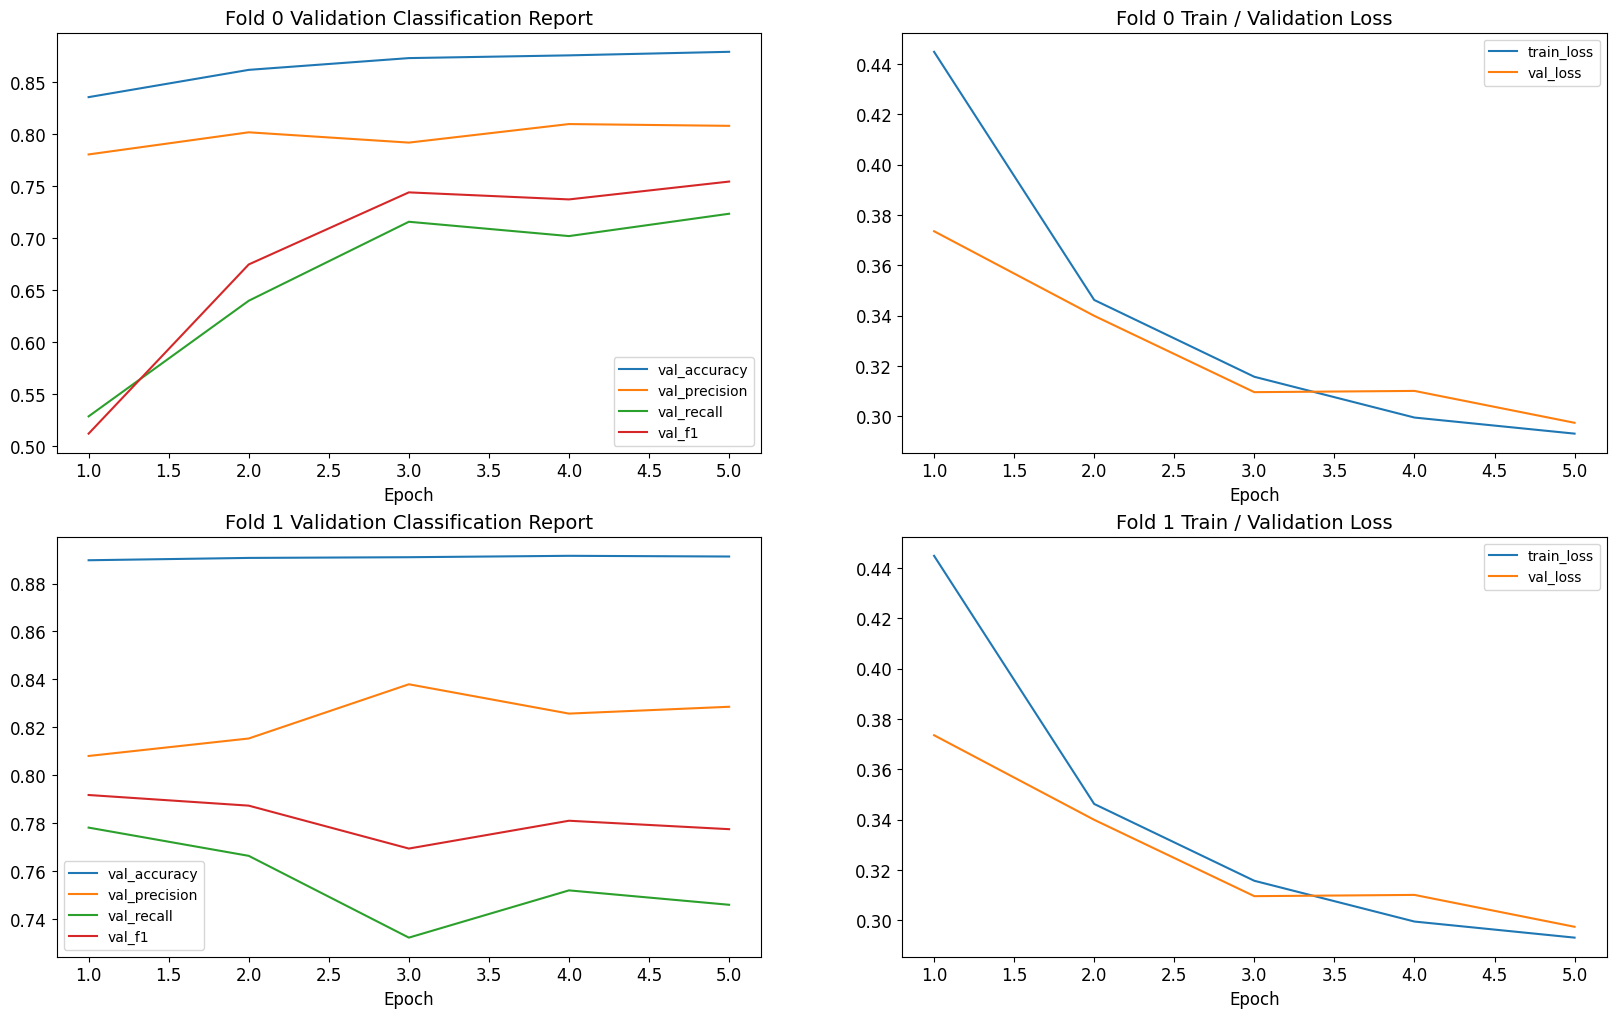

In [ ]:
clf.plot_learning_curve()

## 4.3. Инференс и результаты метрик

In [ ]:
# Инференс

%%time

y_pred = clf.predict(df_test.drop(columns='Категория'))

276/276 [==============================] - 75s 270ms/step
CPU times: user 32 s, sys: 8.36 s, total: 40.4 s
Wall time: 2min 38s


In [ ]:
# Поскольку результат инференса - это вероятности того, что текст является 
# жалобой, то необходимо определить минимальный порог степени уверенности. По
# дефолту это будет 0.65 

confidence = np.where(y_pred < 0.65, 0, 1)

print('Accuracy: {}'.format(accuracy_score(df_test['Категория'], confidence)))
print('Precision: {}'.format(precision_score(df_test['Категория'], confidence)))
print('Recall: {}'.format(recall_score(df_test['Категория'], confidence)))
print('F1: {}'.format(f1_score(df_test['Категория'], confidence)))

Accuracy: 0.8788774002954209
Precision: 0.8223583460949464
Recall: 0.36112979152656355
F1: 0.5018691588785047


# 5. Выводы

Что можно сказать о проделанной работе:

Во-первых, хотелось бы реализовать обучение с созданными метапризнаками, которые пришлось удалить. Вполне возможно, что они бы помогли в данной классификации.

Во-вторых, чистка текста нуждается в больших исследованиях, поскольку, как мне кажется, совсем всё отсеивать в таком датасете, где текст жалобы не всегда сильно отличается от вопроса, может быть банальным решением. К тому же, классы сильно не сбалансированы.

Также были замечены неверно размеченные текста, когда было понятно что это жалобы, но размечены они как вопросы. Возможно, это как одна из причин, почему классы плохо сбалансированы. Было бы желательно такое исправить, хоть это и очень сложная задача.

Теперь, касательно самого обучения, хочется сказать, что 5-ть эпох для каждого фолда (их было 2-а) - это не сильно много. Но так пришлось сделать, в связи с нехваткой времени, которая возникла из-за непредвиденных проблем с метриками, окончательно выяснить причину возникновения которых, к сожалению, так и не удалось. Однако, удалось довести дело до конца и мы можем дать этому оценку.

Во время обучения, на тренировочном и валидационном наборах данных все 4-ре метрики росли, а ошибка неуклонно снижалась. Менее эффективно себя показало Accuracy, в ней слабо выражалась какая-либо динамика. Остальные метрики показывали динамику в сторону роста. Однако, на втором фолде, их динамика выразилась только в виде "провала" на графике, а далее их немного отклоняло то в рост, то на убыль. Здесь может показаться, что модель начала переобучаться, но для такого вывода необходимо провести ряд исследований с большим количеством эпох и кросс-валидаций. Однако результаты метрик на тестовых данных, намекают на то, что модель переобучилась. Даже тоже Accuracy намекает на то, что модель просто начала предсказывать одни нули (вопросы), процент которых был примерно такой же (0.83), какой показывает Accuracy (0.87). Разницу между ними в 0.04, можно объяснить случайной перебалансировкой из-за разбиения данных на тренировочную и тестовую выборки. Плюс большой разброс значений между Precision (0.82) и Recall (0.36), наводит на желание применить метрику ROC-AUC, желательно, в виде графика, чтобы выяснить природу такого разброса. Ну а F1 в 0.5, говорит нам просто об "усреднении" Precision и Recall, поскольку является их среднегармоническим. 

В общем нужно больше исследований :)

Из пожеланий к созданной архитектуре модели, хотелось бы добавить чек-поинты и раннюю остановку, как минимум. Как максимум, поиграться со слоями и возможно добавить слои дроп-аутов, чтобы уменьшить переобучаемость модели.

Хотелось бы подчеркнуть, что одни из основных проблем датасета, это жуткий дисбаланс и, скорей всего, неверно размеченные данные. Возможно, метапризнаки помогли бы решить эти проблемы. Интересно этот момент изучить.

Спасибо сотрудникам компании "Диалог" за интересную задачу с реальными данными. Было очень познавательно и интересно решать трудности, с которыми мне пришлось сталкиваться, в том числе, с нехваткой вычислительных мощностей :)